<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 223 (delta 59), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (223/223), 7.39 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, var_types = data_loader.prepare_original_dataset(original_df)

print(f"Shape of original data: {original_df.shape}")
print(f"Shape of data set we analyze: {project_data.shape}")

Shape of original data: (14765, 305)
Shape of data set we analyze: (14765, 108)


# Vectorizing the data set

In [10]:
# Data Transformation
vectorizer = Table2Vector(var_types)

# Vectorizing *without* indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

vectorized_df.shape

(14765, 563)

In [11]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [12]:
from tensorflow.keras.models import load_model
import gcsfs

# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.h5"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.h5"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())

# Load the model from the local file
model = load_model(local_model_path)


## Making Predictions and Filling in the Missing Values


In [13]:
import numpy as np

# Fill the missing values with some initial guess. Here, the median of each column is used.
filled = vectorized_df.fillna(vectorized_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-4
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = vectorized_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


462/462 [==============================] - 1s 2ms/step


In [14]:
filled

weight  stheight  stweight       bmi    bmipct  \
0      0.508875  0.587383  0.303695  0.108749  0.656014   
1      0.347927  0.454057  0.275584  0.122809  0.673284   
2      0.142144  0.414373  0.250520  0.110779  0.653784   
3      0.161873  0.658366  0.323913  0.101454  0.611447   
4      0.415955  0.454114  0.248274  0.115395  0.623534   
...         ...       ...       ...       ...       ...   
14760  0.018136  0.537631  0.282137  0.103367  0.647649   
14761  0.030378  0.741739  0.429419  0.121699  0.424226   
14762  0.021987  0.670679  0.388659  0.117144  0.483297   
14763  0.087971  0.577465  0.188926  0.082226  0.089027   
14764  0.057658  0.540384  0.283073  0.105263  0.620831   

       age__12 years old or younger  age__13 years old  age__14 years old  \
0                               0.0                0.0                0.0   
1                               0.0                0.0                0.0   
2                               0.0                0.0                0.0   
3                               0.0                0.0                0.0   
4                               0.0                0.0                0.0   
...                             ...                ...                ...   
14760                           0.0                0.0                0.0   
14761                           0.0                0.0                0.0   
14762                           0.0                0.0                0.0   
14763                           0.0                0.0                0.0   
14764                           0.0                0.0                0.0   

       age__15 years old  age__16 years old  ...  sunburn__2 times  \
0                    0.0                0.0  ...               1.0   
1                    0.0                0.0  ...               0.0   
2                    0.0                0.0  ...               0.0   
3                    0.0                0.0  ...               0.0   
4                    0.0                0.0  ...               0.0   
...                  ...                ...  ...               ...   
14760                0.0                0.0  ...               0.0   
14761                0.0                0.0  ...               0.0   
14762                0.0                0.0  ...               0.0   
14763                0.0                0.0  ...               0.0   
14764                0.0                0.0  ...               0.0   

       sunburn__3 times  sunburn__4 times  sunburn__5 or more times  \
0                   0.0               0.0                       0.0   
1                   0.0               0.0                       0.0   
2                   0.0               0.0                       0.0   
3                   0.0               0.0                       0.0   
4                   0.0               0.0                       0.0   
...                 ...               ...                       ...   
14760               0.0               0.0                       0.0   
14761               0.0               0.0                       0.0   
14762               0.0               0.0                       0.0   
14763               0.0               0.0                       0.0   
14764               0.0               0.0                       0.0   

       difficulty_concentrating__No  difficulty_concentrating__Yes  \
0                               0.0                            1.0   
1                               0.0                            1.0   
2                               1.0                            0.0   
3                               1.0                            0.0   
4                               0.0                            0.0   
...                             ...                            ...   
14760                           0.0                            0.0   
14761                           0.0                            0.0   
14762                           0.0                

Now that we have filled in the original dataset with the most likely values for their missing values, we run the Autoencoder on the filled vectorized dataset.

In [15]:
predicted = pd.DataFrame(model.predict(filled))
predicted.columns = filled.columns
predicted

462/462 [==============================] - 1s 2ms/step


weight  stheight  stweight       bmi    bmipct  \
0      0.195940  0.587383  0.303695  0.108749  0.656014   
1      0.263337  0.454057  0.275584  0.122809  0.673284   
2      0.205978  0.414373  0.250520  0.110779  0.653784   
3      0.302605  0.658366  0.323913  0.101454  0.611447   
4      0.281063  0.454114  0.248274  0.115395  0.623534   
...         ...       ...       ...       ...       ...   
14760  0.114345  0.537631  0.282137  0.103367  0.647649   
14761  0.391164  0.741739  0.429419  0.121699  0.424226   
14762  0.344380  0.670679  0.388659  0.117144  0.483297   
14763  0.051522  0.514316  0.261946  0.108373  0.635011   
14764  0.058016  0.540384  0.283073  0.105263  0.620831   

       age__12 years old or younger  age__13 years old  age__14 years old  \
0                          0.004342           0.000399           0.004700   
1                         -0.000876           0.009795           0.213273   
2                          0.006186          -0.003660          -0.008078   
3                          0.007518          -0.004720          -0.007744   
4                         -0.007376           0.012458           0.249511   
...                             ...                ...                ...   
14760                      0.015887           0.009070           0.239337   
14761                     -0.027101          -0.002514           0.056669   
14762                     -0.016611          -0.001717           0.076165   
14763                     -0.000254           0.034823           0.282097   
14764                      0.043632           0.003529           0.111084   

       age__15 years old  age__16 years old  ...  sunburn__2 times  \
0               0.125434           0.287198  ...          0.065132   
1               0.291144           0.261416  ...          0.122521   
2               0.131690           0.287244  ...          0.118993   
3               0.102033           0.210764  ...          0.200127   
4               0.327658           0.224280  ...          0.128449   
...                  ...                ...  ...               ...   
14760           0.269693           0.191635  ...          0.051841   
14761           0.055817           0.611357  ...          0.111264   
14762           0.104873           0.504760  ...          0.100955   
14763           0.297876           0.238601  ...          0.010889   
14764           0.208876           0.238487  ...          0.036099   

       sunburn__3 times  sunburn__4 times  sunburn__5 or more times  \
0              0.022069         -0.006557                  0.031244   
1              0.075502          0.039061                  0.075076   
2              0.077814          0.061824                  0.083983   
3              0.123818          0.049946                  0.230163   
4              0.088912          0.034333                  0.080152   
...                 ...               ...                       ...   
14760          0.004565          0.015928                  0.002771   
14761          0.255887          0.149168                  0.435657   
14762          0.184215          0.122476                  0.332659   
14763         -0.005721         -0.009699                 -0.006203   
14764          0.001624         -0.001178                  0.044528   

       difficulty_concentrating__No  difficulty_concentrating__Yes  \
0                          0.674547                       0.240736   
1                          0.230557                       0.605510   
2                          0.344634                       0.509776   
3                          0.678813                       0.312103   
4                          0.295881                       0.506447   
...                             ...                            ...   
14760                      0.062070                       0.020613   
14761                      0.528368                       0.562337   
14762                      0.383197                

In [16]:
tabular_from_predicted = vectorizer.tabularize_vector(predicted)

## Visualization of the original vs reconstructed

weight


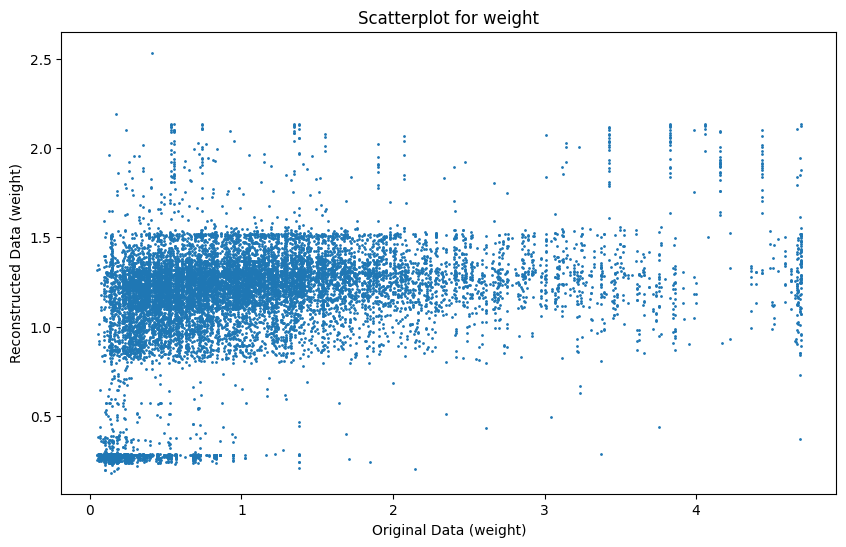

stheight


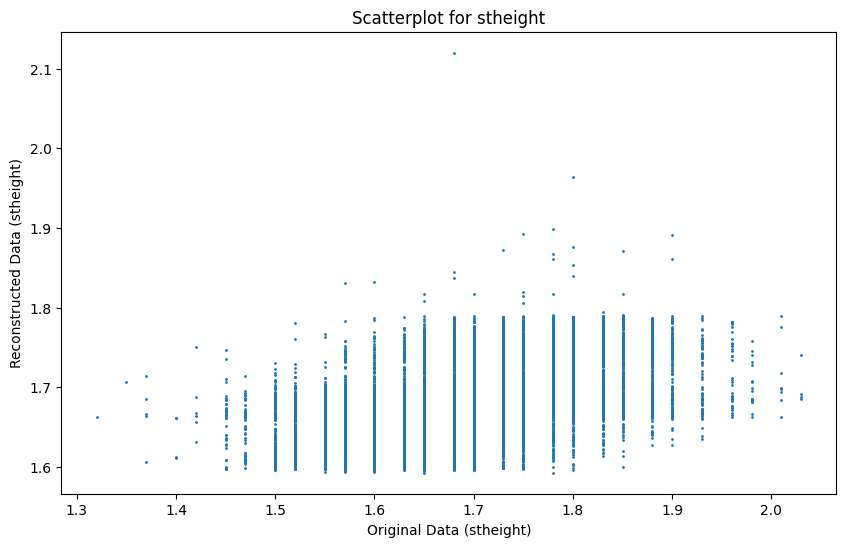

stweight


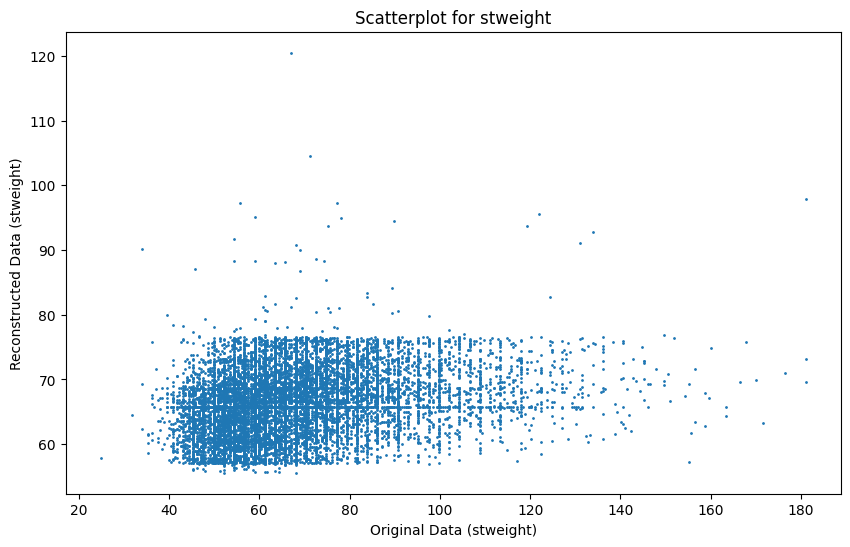

bmi


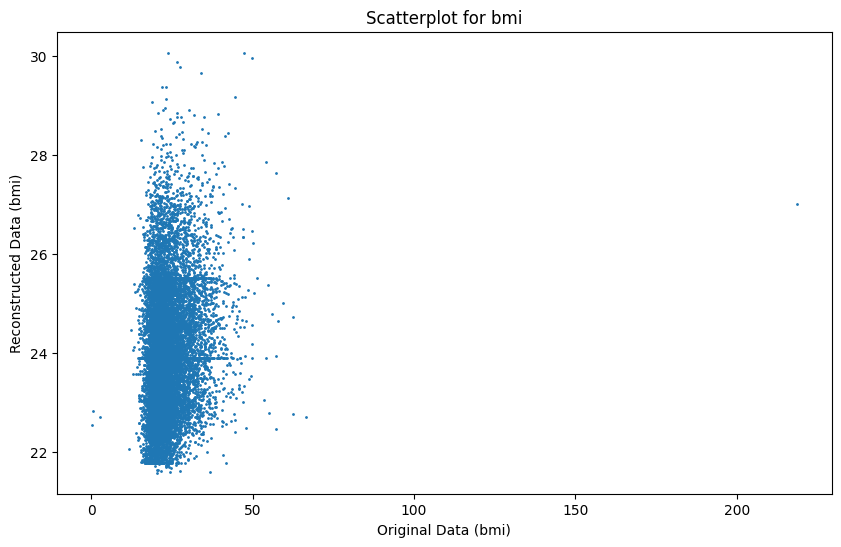

bmipct


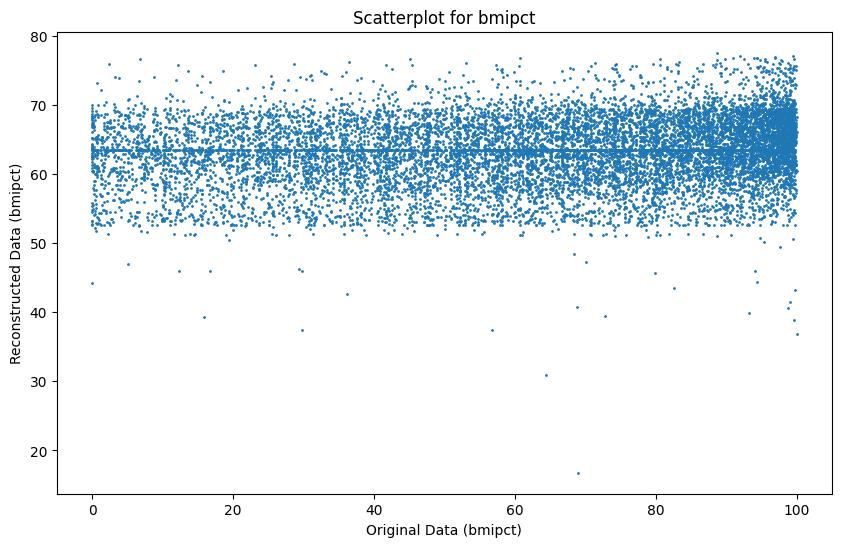

In [17]:
import matplotlib.pyplot as plt

def create_scatterplot_for_numeric(original_df, predicted_df, numeric_attr):
  plt.figure(figsize=(10, 6))  # Create a new figure with a particular size
  plt.scatter(original_df[numeric_attr], predicted_df[numeric_attr], s=1)  # Create a scatterplot
  plt.xlabel(f'Original Data ({numeric_attr})')  # Set the x-axis label
  plt.ylabel(f'Reconstructed Data ({numeric_attr})')  # Set the y-axis label
  plt.title(f'Scatterplot for {numeric_attr}')  # Set the plot title
  plt.show()  # Display the plot

for v in var_types.keys():
  if var_types[v] == 'numeric':
    print(v)
    create_scatterplot_for_numeric(project_data, tabular_from_predicted, v)



age


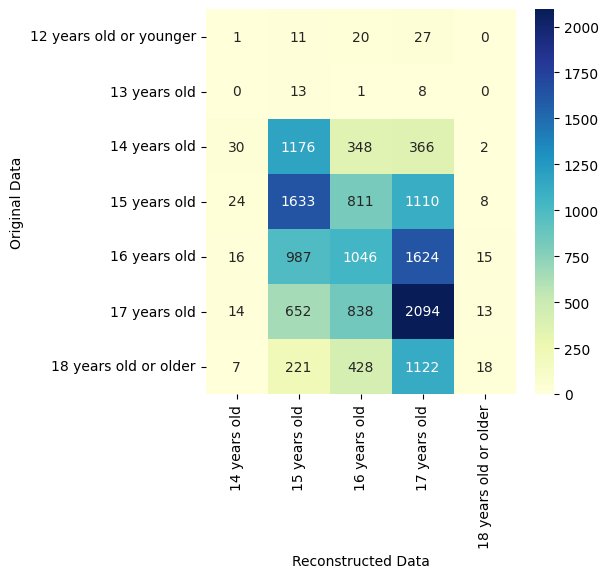

sex


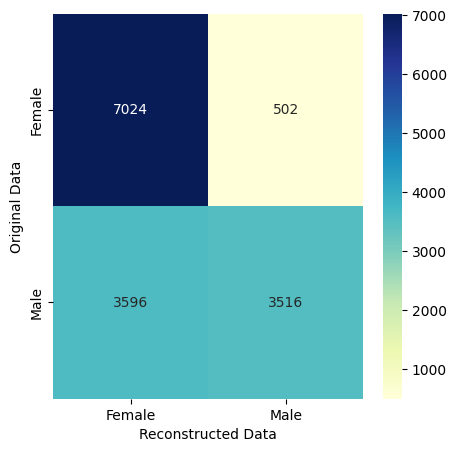

grade


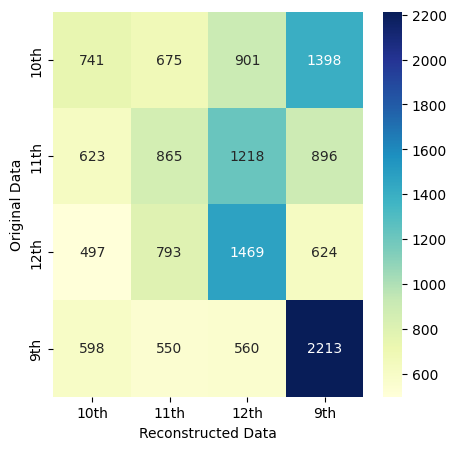

Hispanic_or_Latino


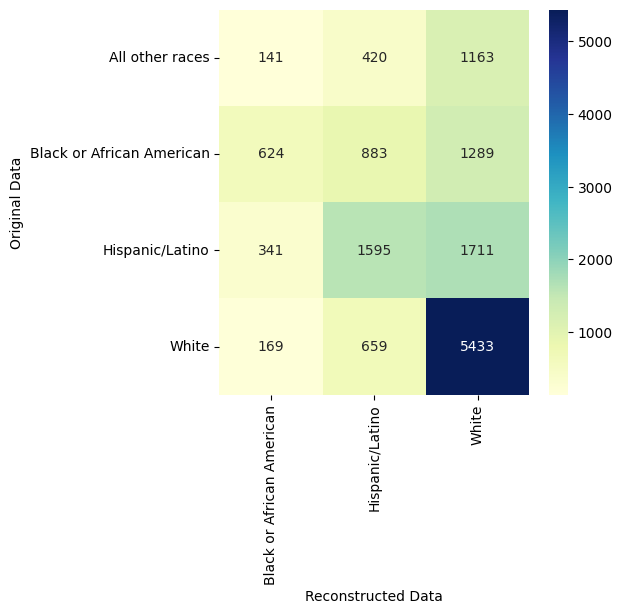

race


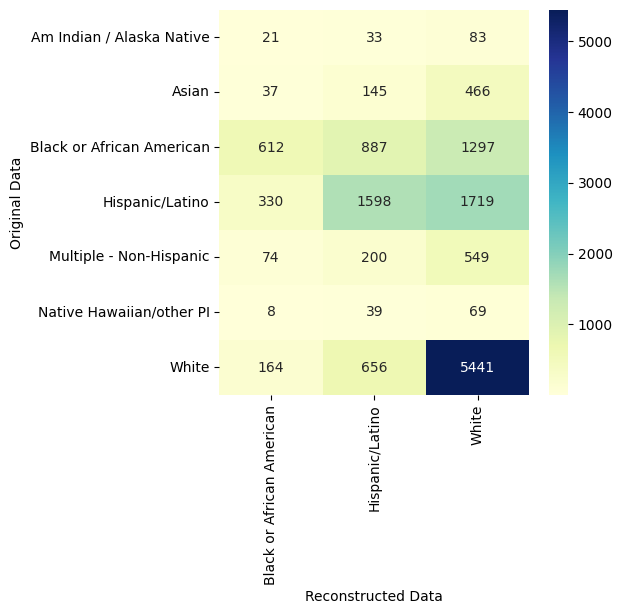

obese


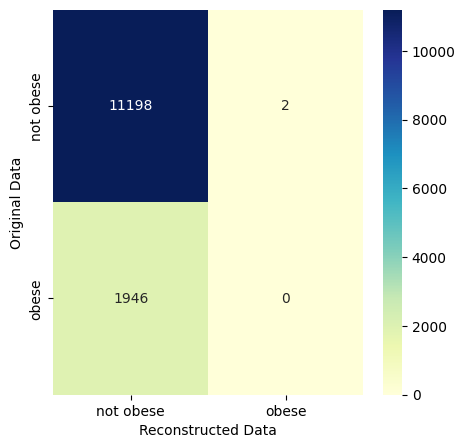

overweight


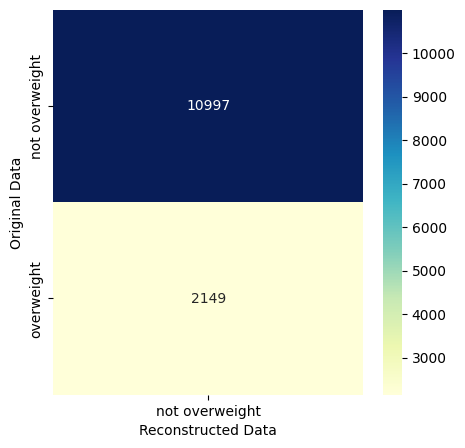

sexual_identity


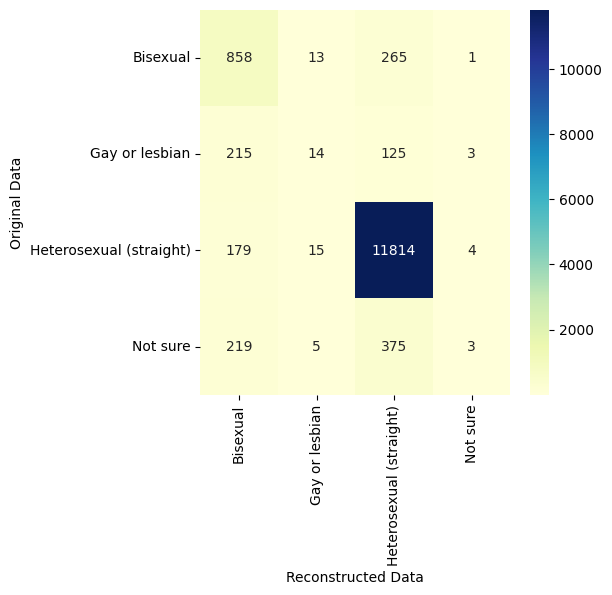

sex/sexual_contacts


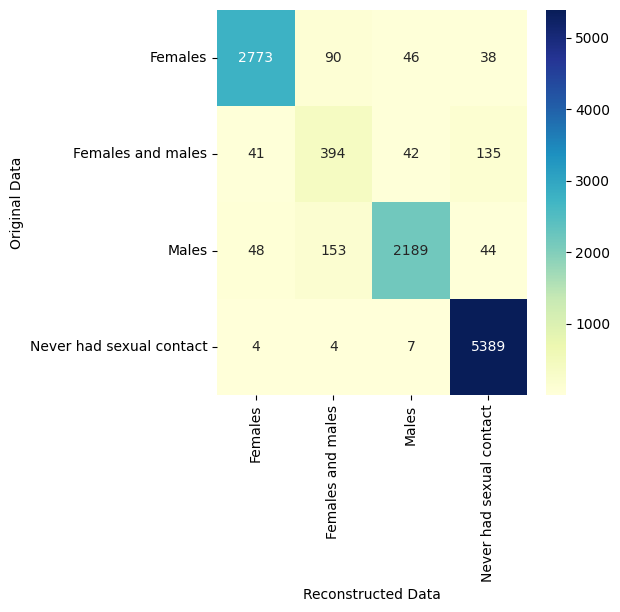

sexid


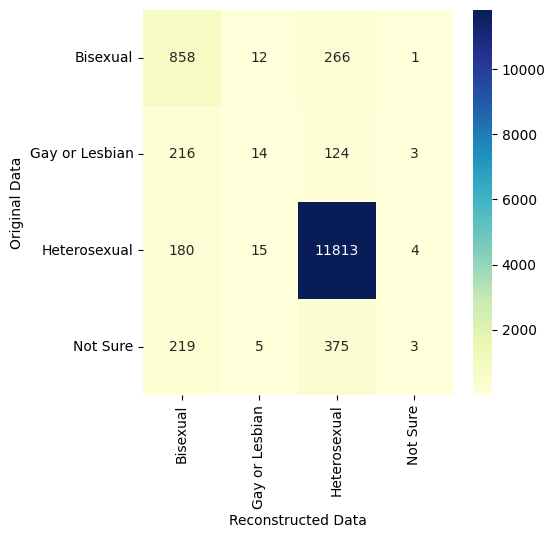

sexid2


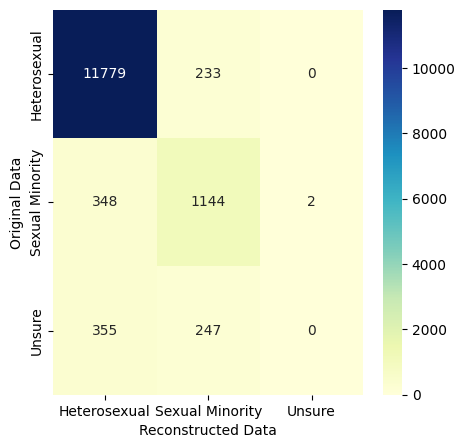

sexpart


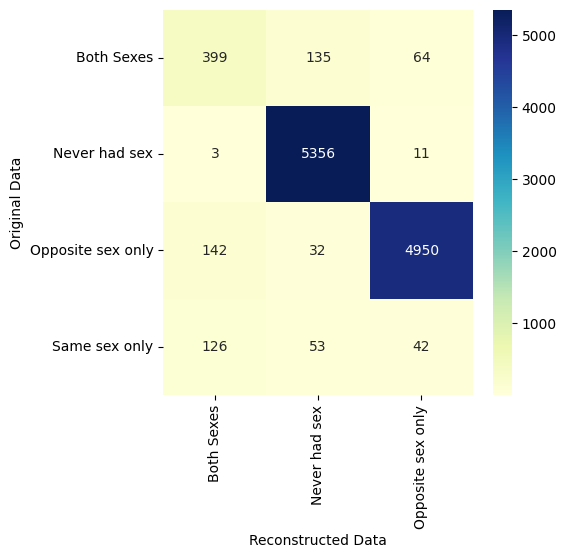

sexpart2


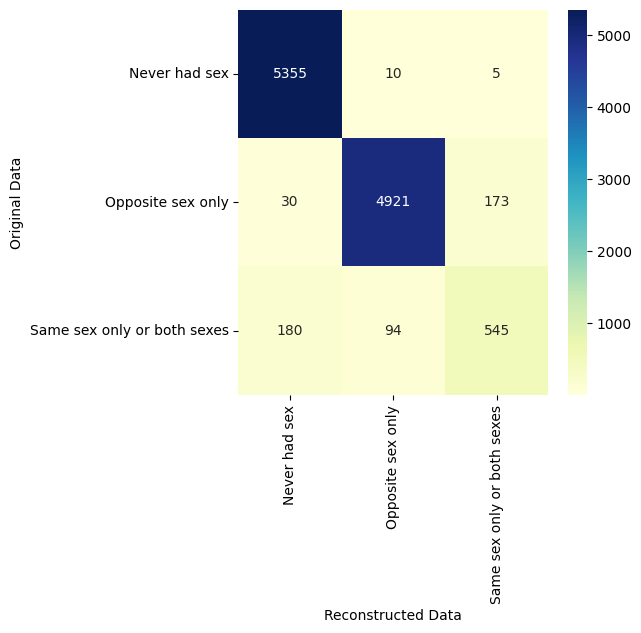

seat_belt_use


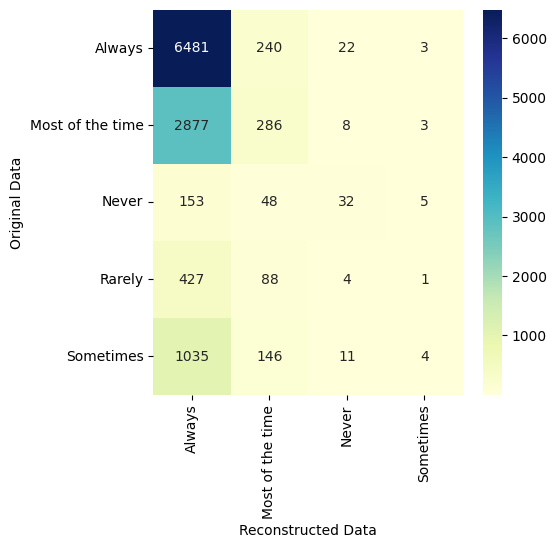

riding_with_a_drinking_driver


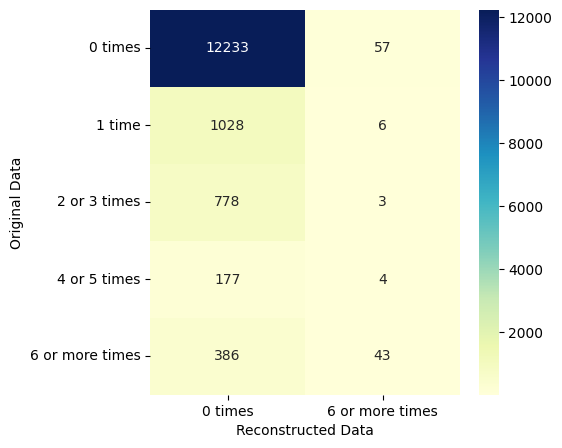

drinking_and_driving


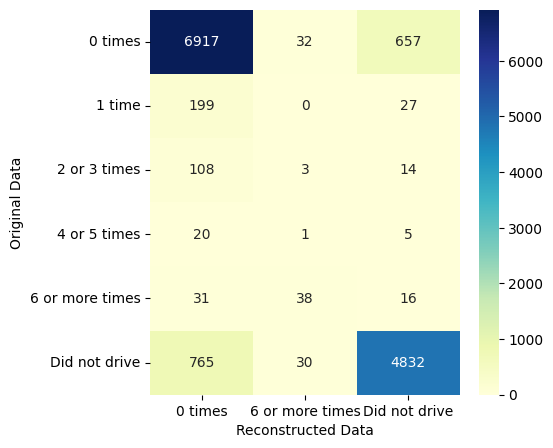

texting_and_driving


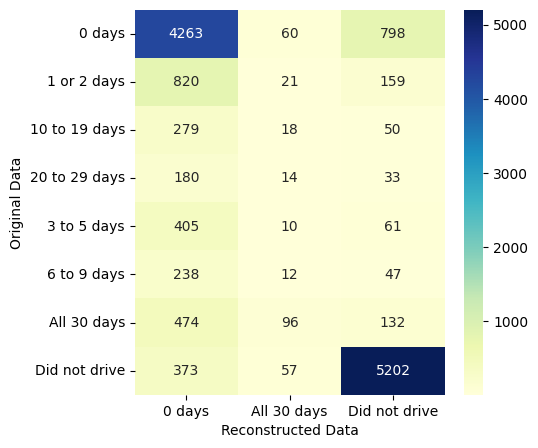

weapon_carrying


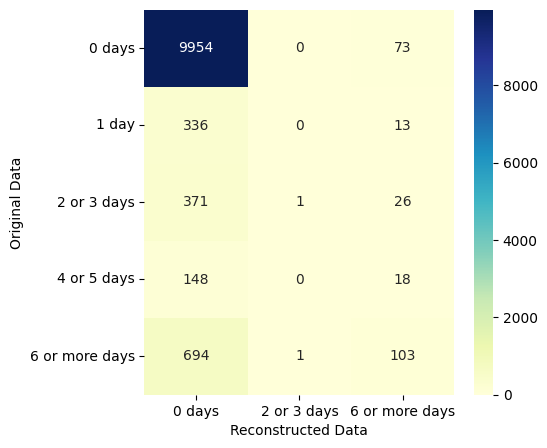

weapon_carrying_at_school


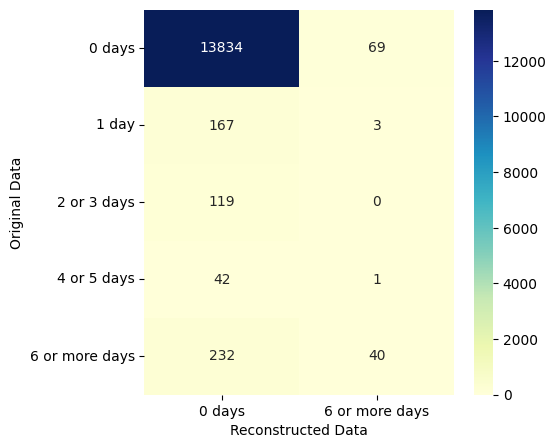

gun_carrying_past_12_mos


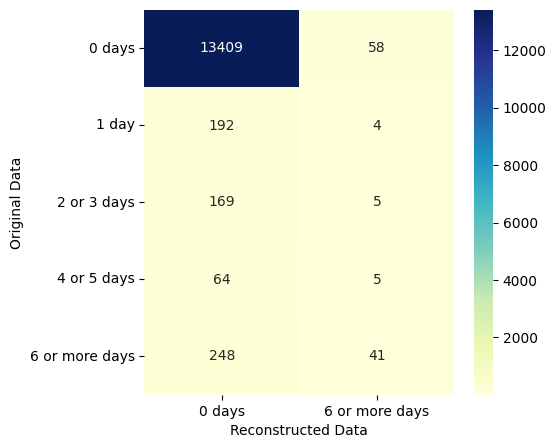

safety_concerns_at_school


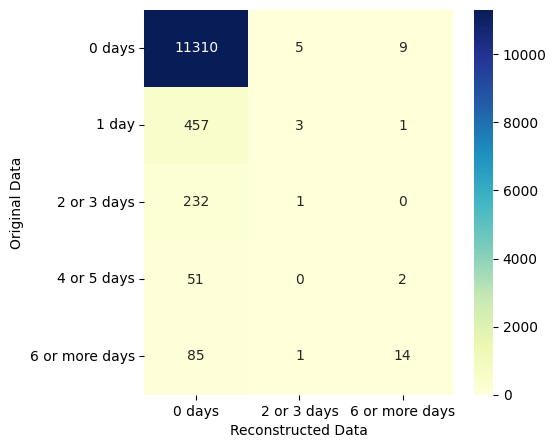

threatened_at_school


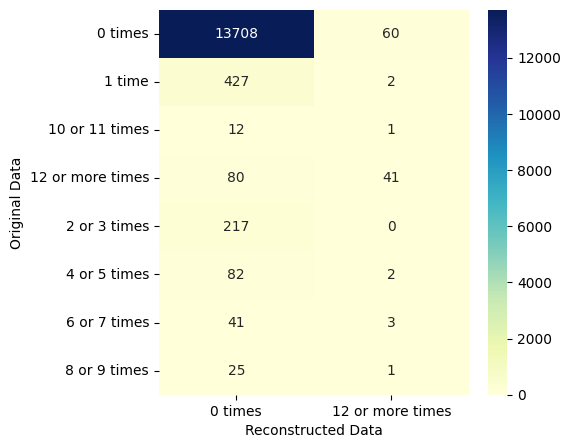

physical_fighting


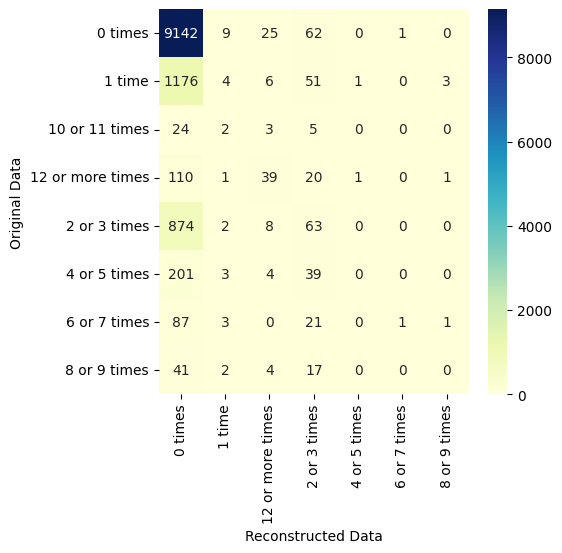

physical_fighting_at_school


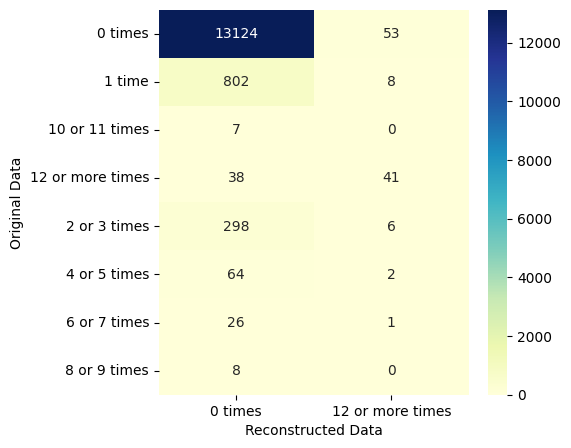

forced_sexual_intercourse


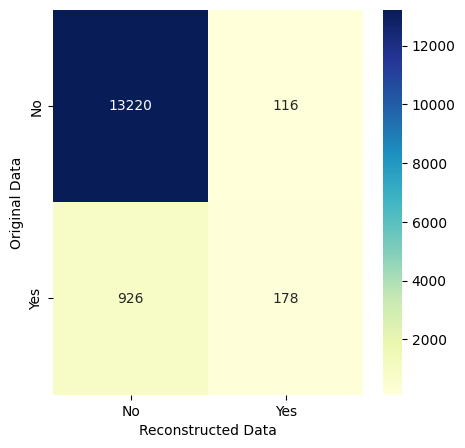

sexual_violence


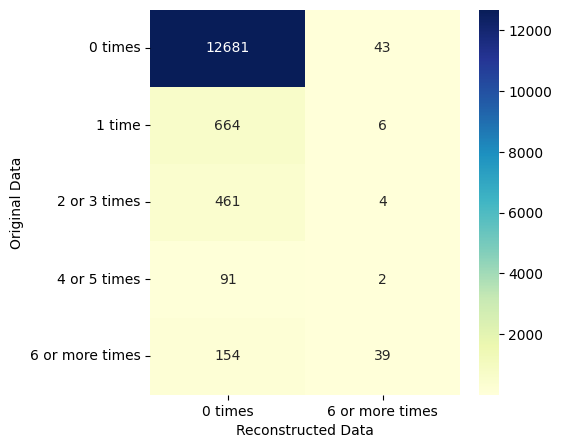

sexual_dating_violence


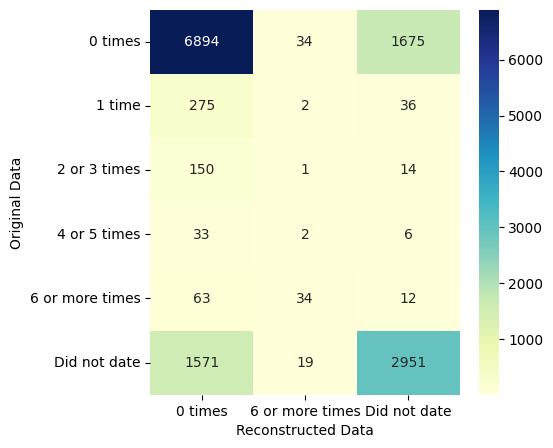

physical_dating_violence


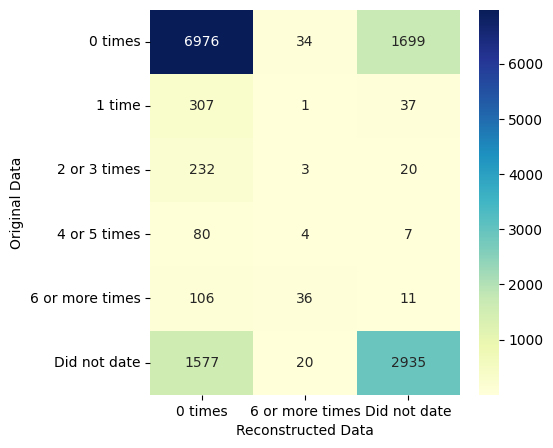

bullying_at_school


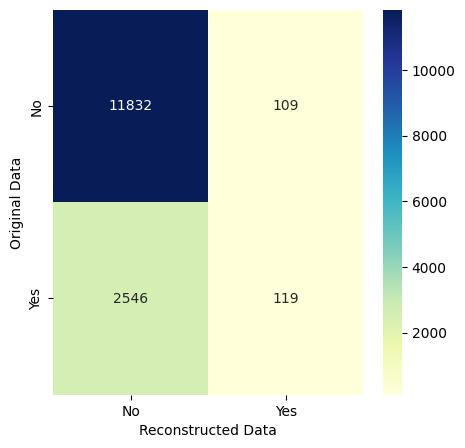

electronic_bullying


sad_or_hopeless


considered_suicide


made_a_suicide_plan


attempted_suicide


injurious_suicide_attempt


ever_cigarette_use


initation_of_cigarette_smoking


current_cigarette_use


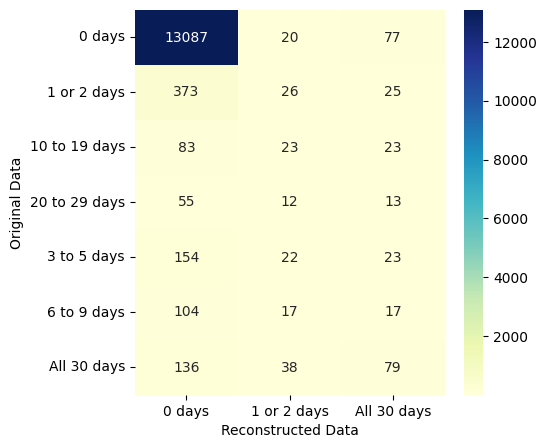

smoking_amounts_per_day


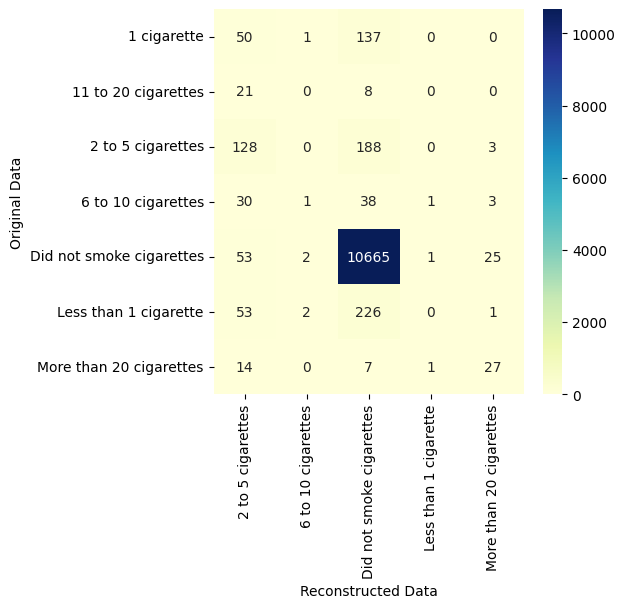

electronic_vapor_product_use


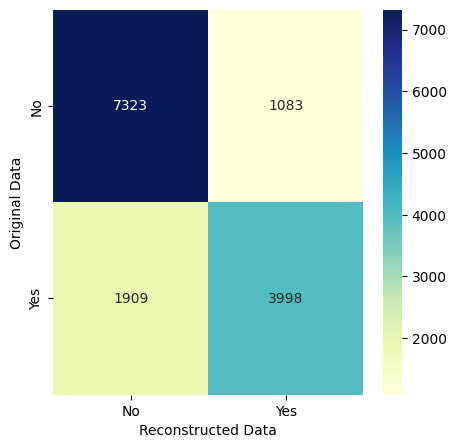

current_electronic_vapor_product_use


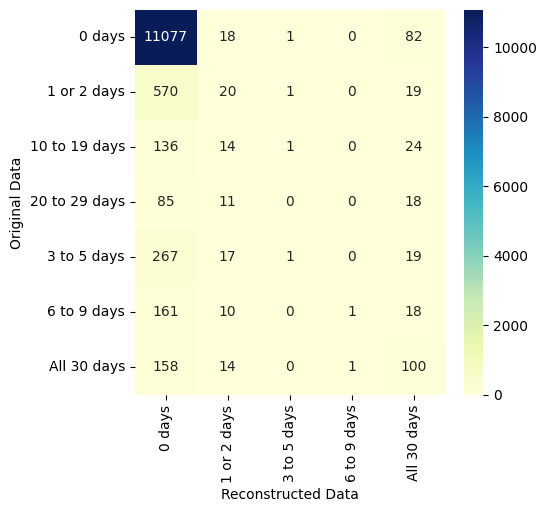

EVP_from_store


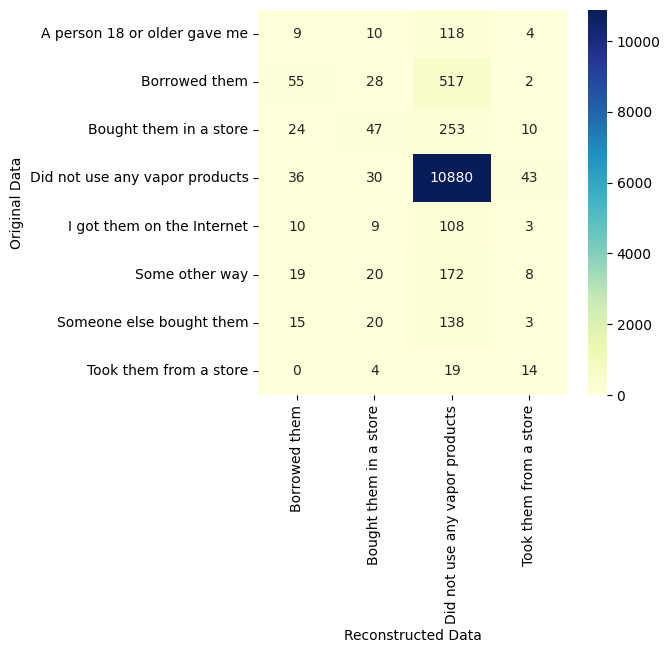

current_smokeless_tobacco_use


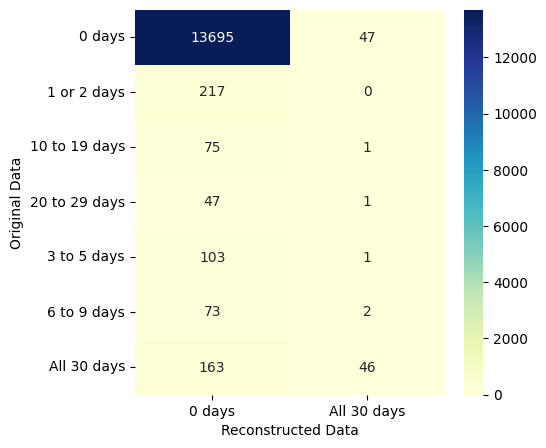

current_cigar_use


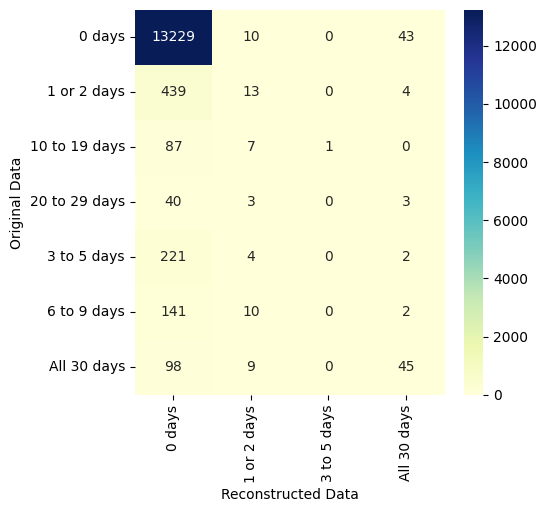

all_tobacco_product_cessation


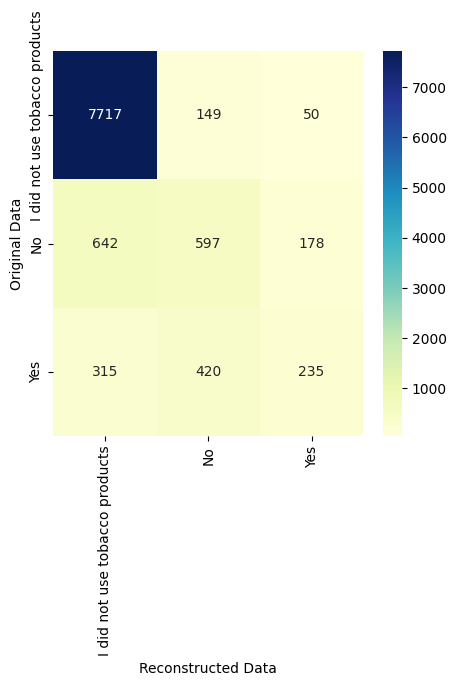

ever_alcohol_use


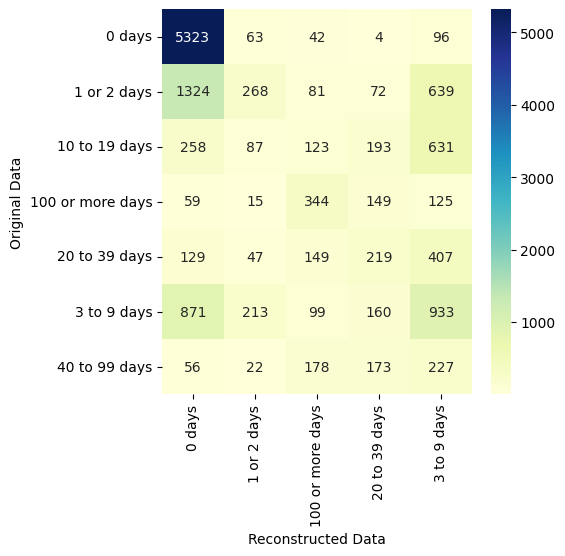

initiation_of_alcohol_use


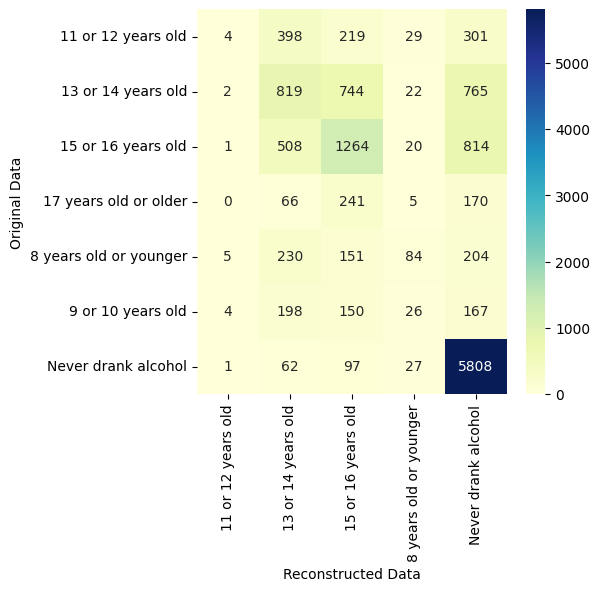

current_alcohol_use


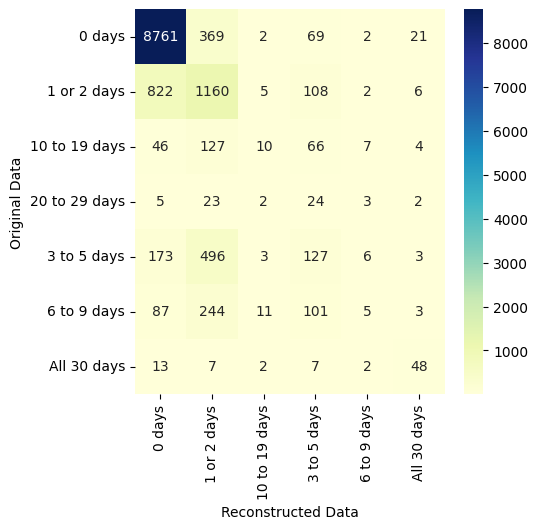

source_of_alcohol


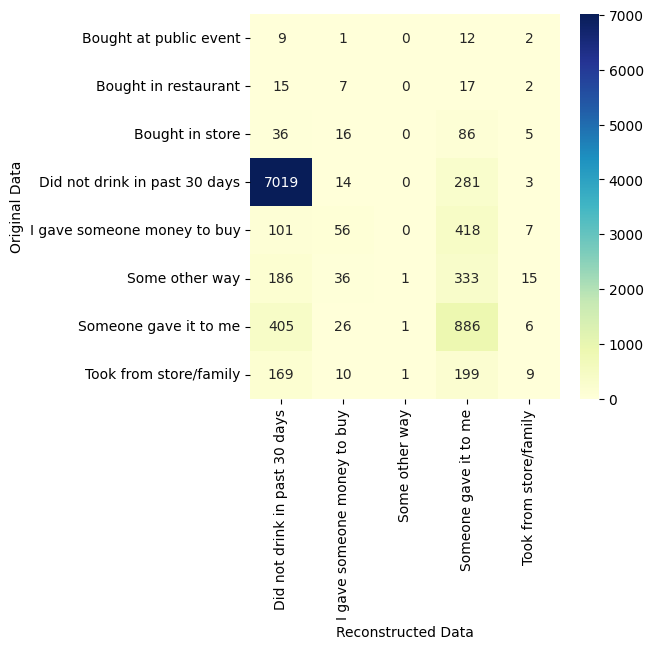

current_binge_drinking


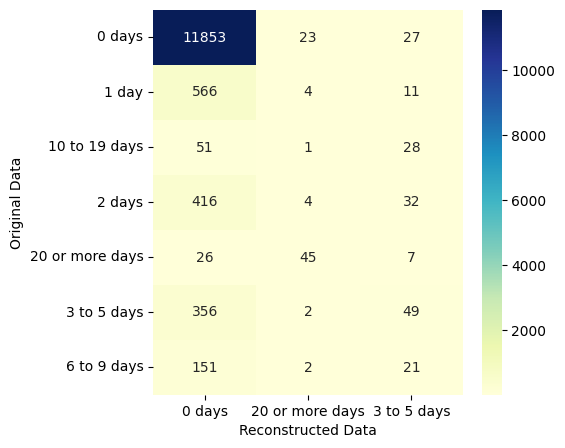

largest_number_of_drinks


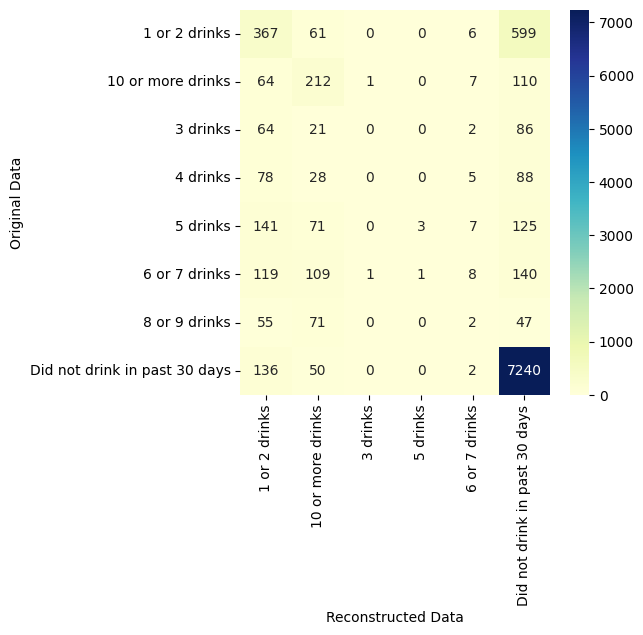

ever_marijuana_use


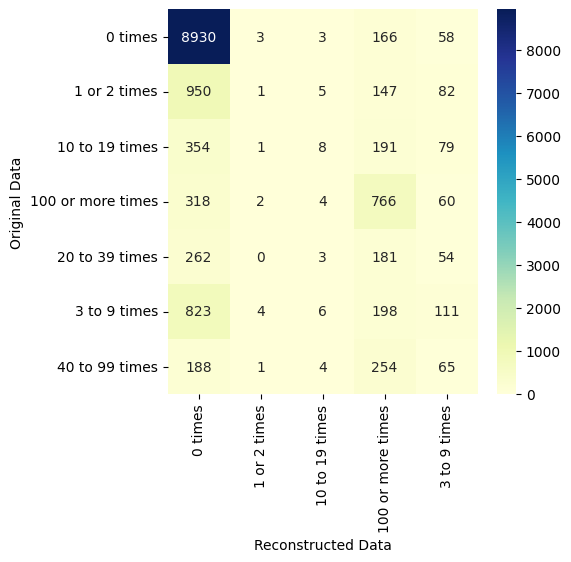

initiation_of_marijuana_use


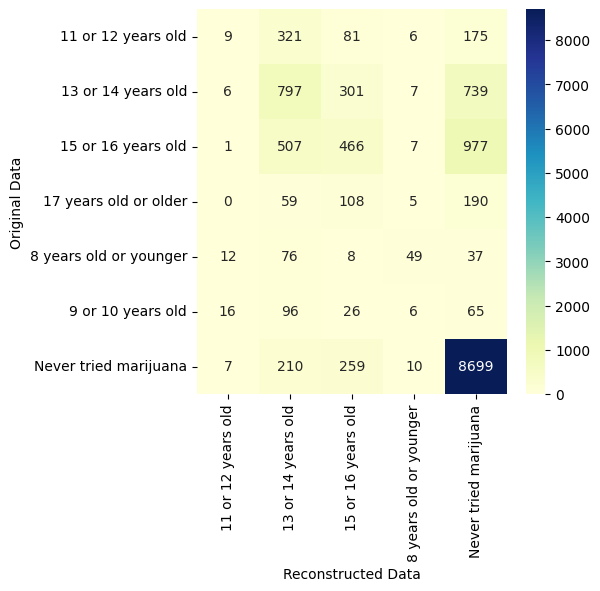

current_marijuana_use


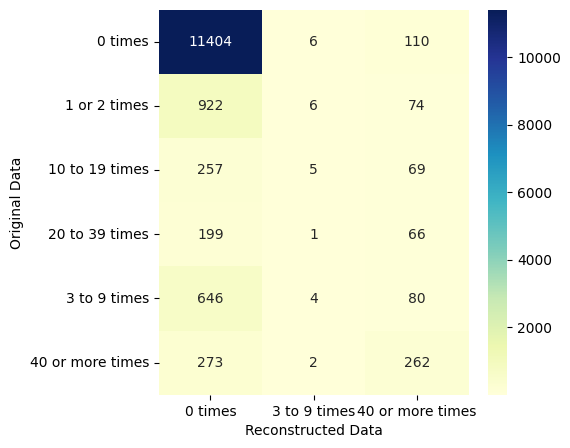

ever_cocaine_use


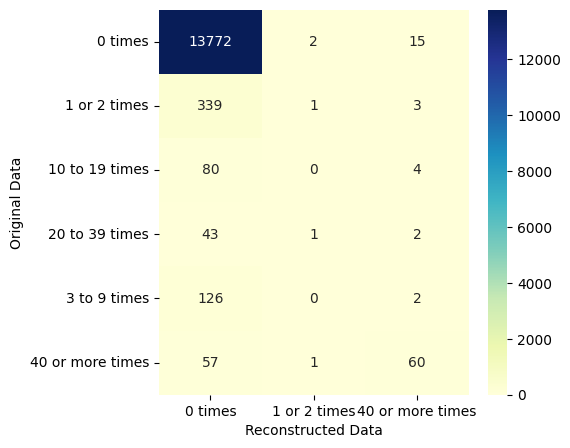

ever_inhalant_use


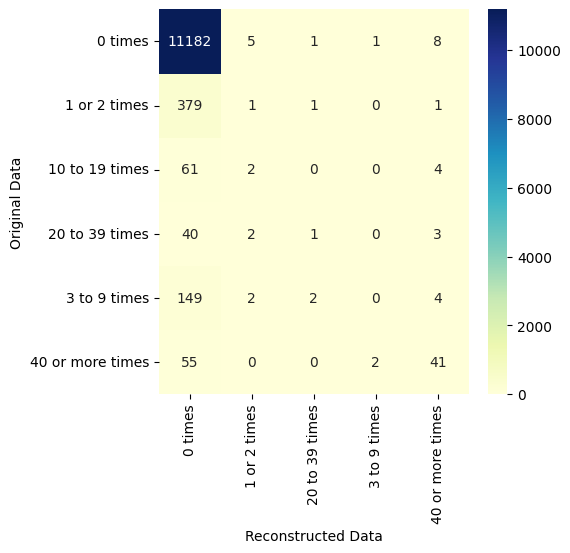

ever_heroin_use


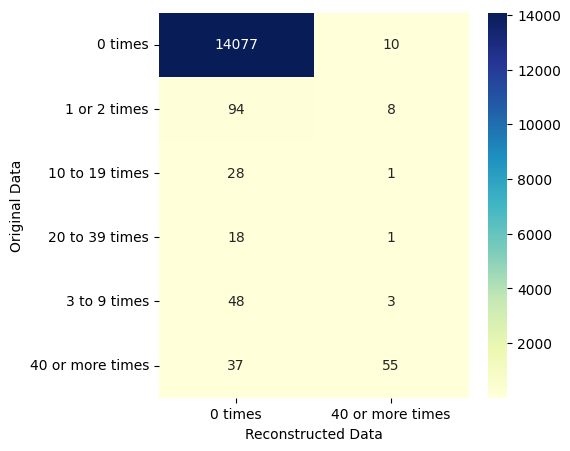

ever_methamphetamine_use


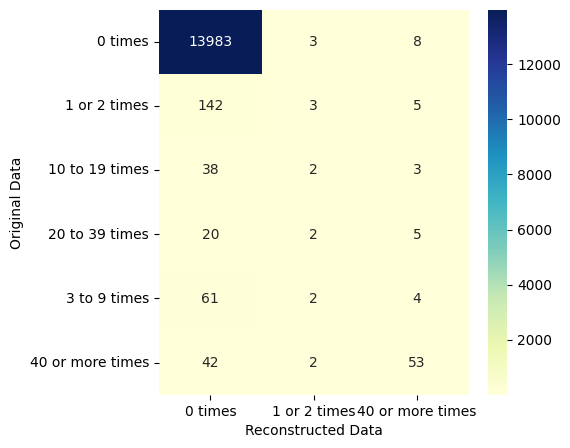

ever_ecstasy_use


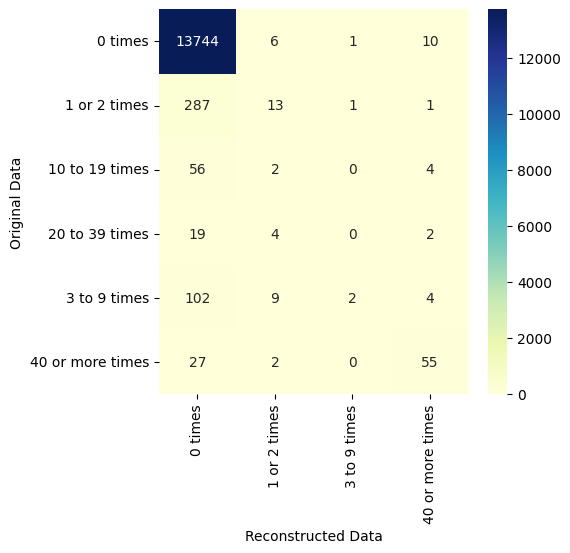

ever_synthetic_marijuana_use


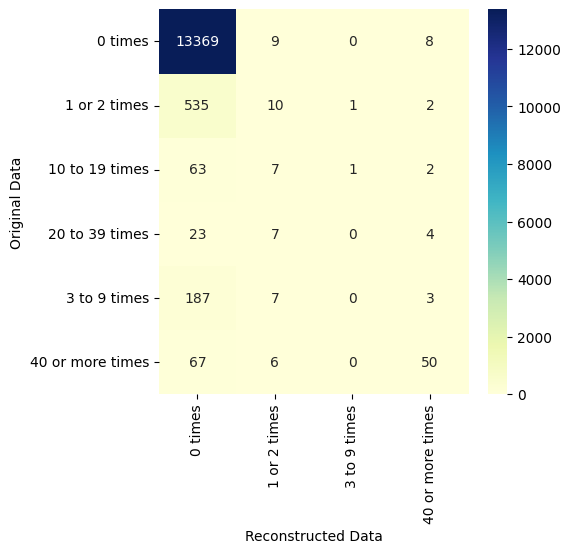

ever_steroid_use


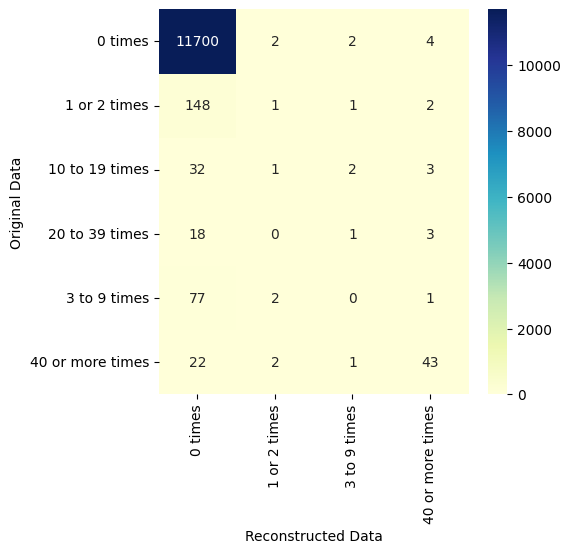

ever_prescription_pain_medicine_use


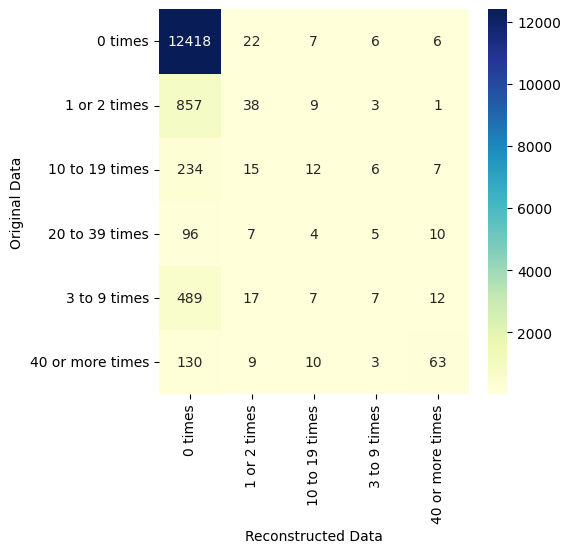

illegal_injected_drug_use


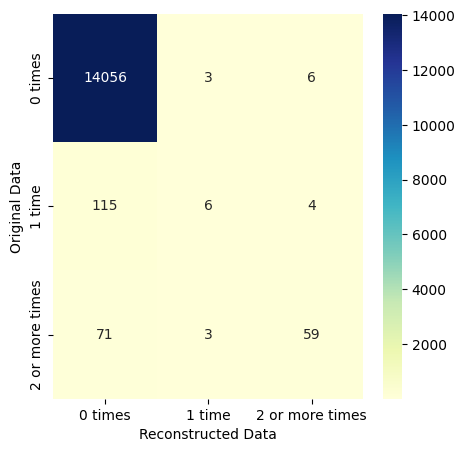

illegal_drugs_at_school


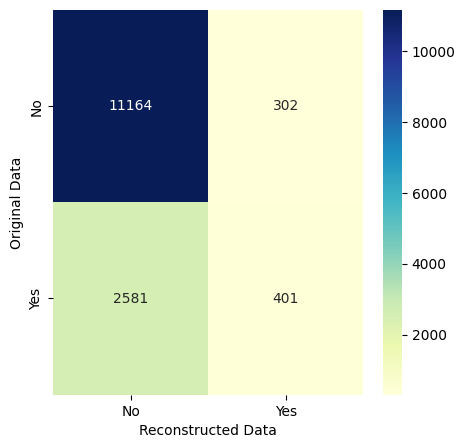

ever_sexual_intercourse


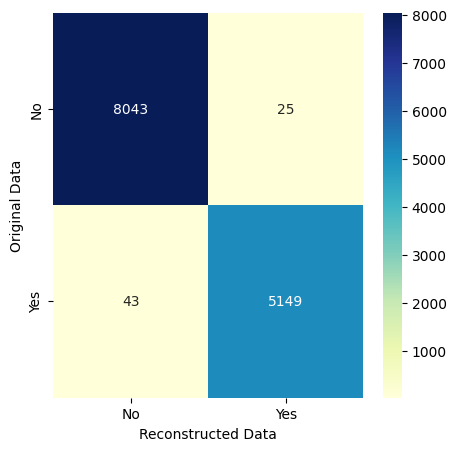

first_sex_intercourse


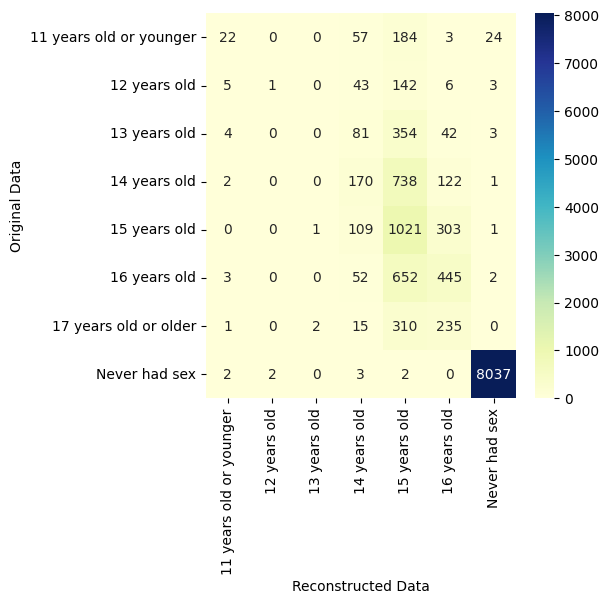

multiple_sex_partners


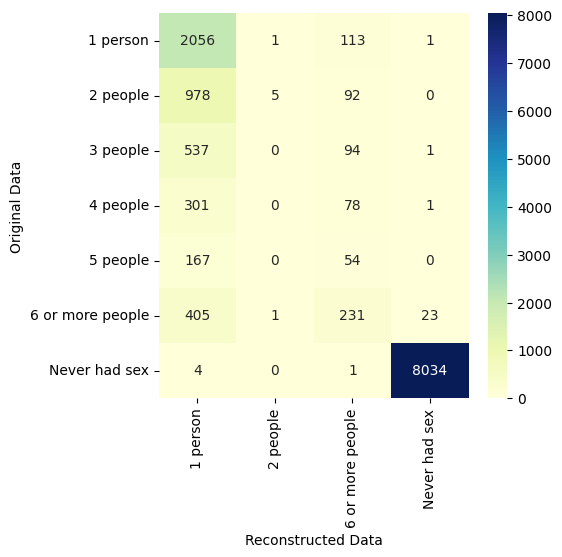

current_sexual_activity


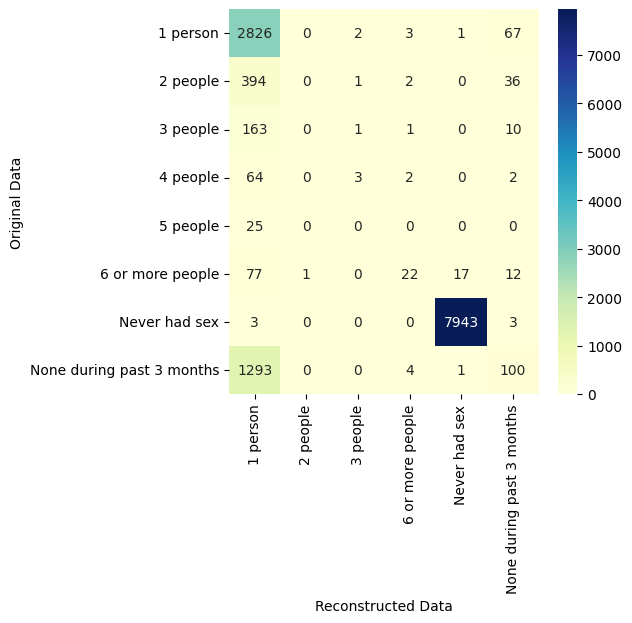

alcohol/drugs_at_sex


condom_use


birth_control_pill_use


perception_of_weight


weight_loss


fruit_juice_drinking


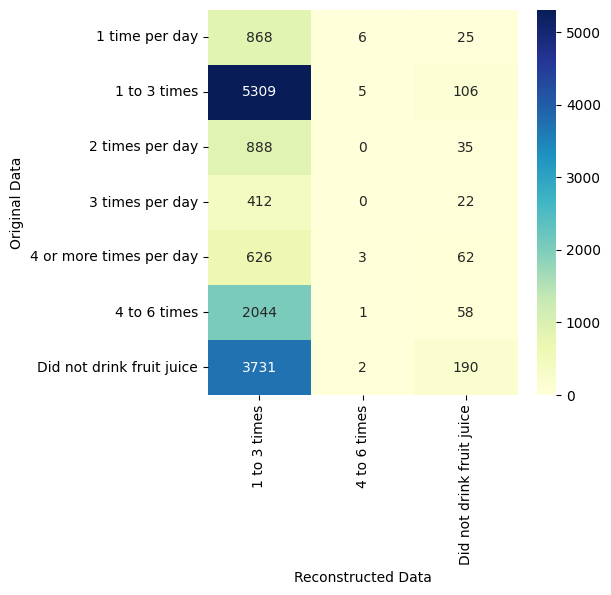

fruit_eating


green _salad_eating


potato_eating


carrot_eating


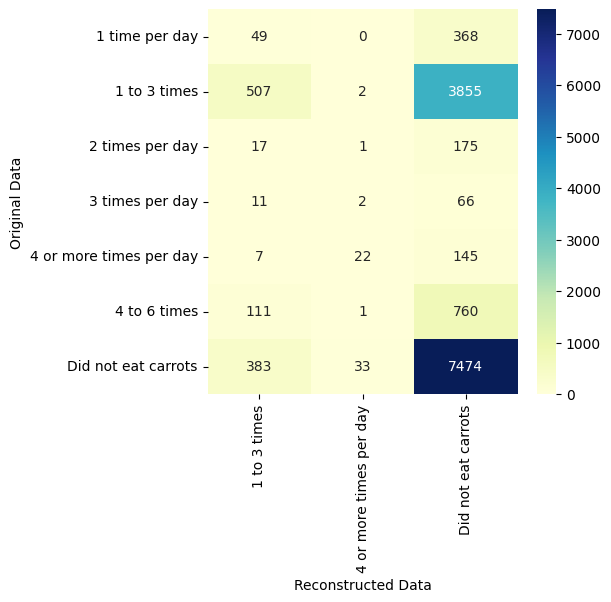

other_vegetable_eating


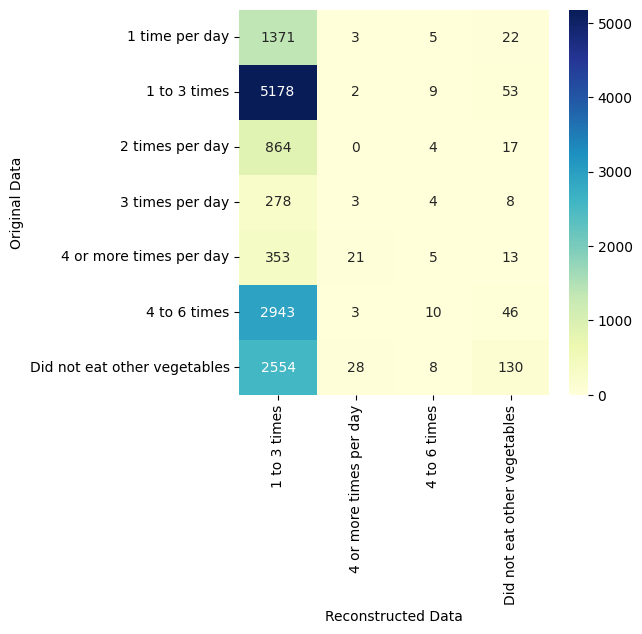

soda_drinking


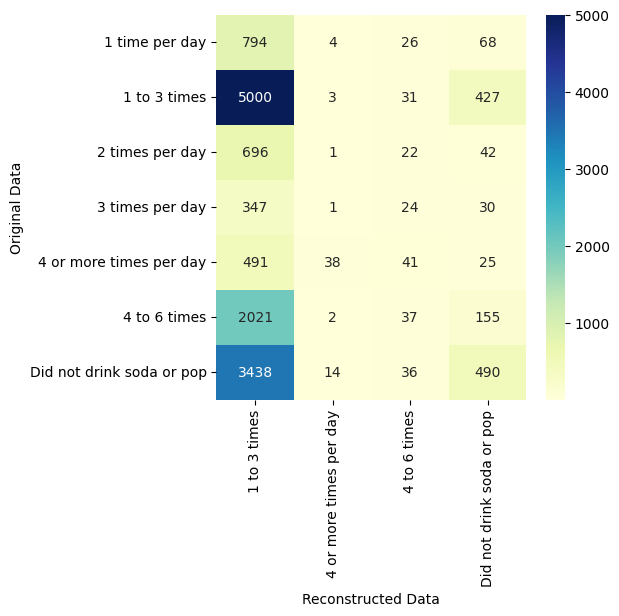

milk_drinking


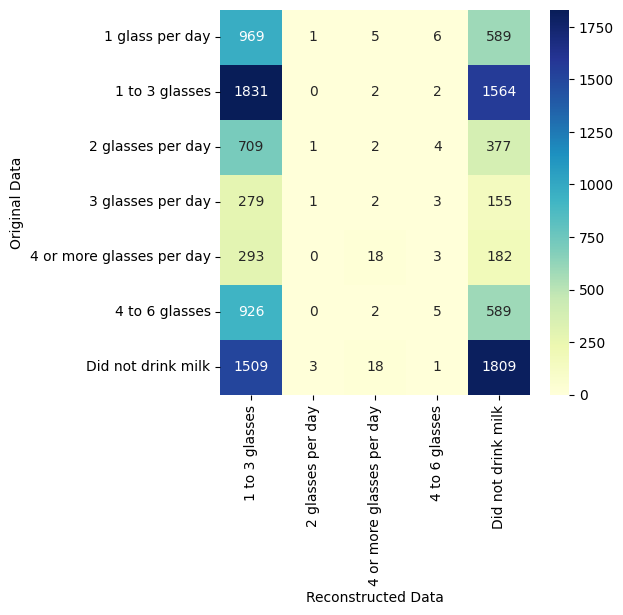

breakfast_eating


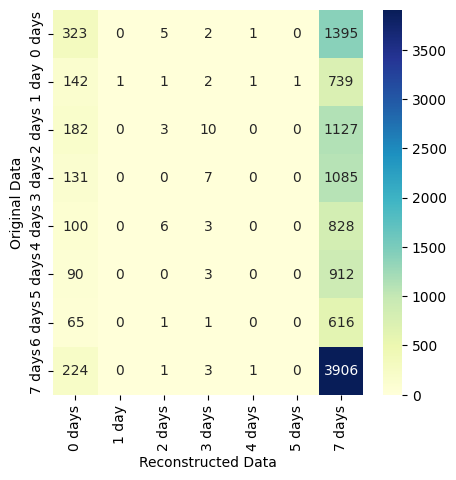

physical_activity


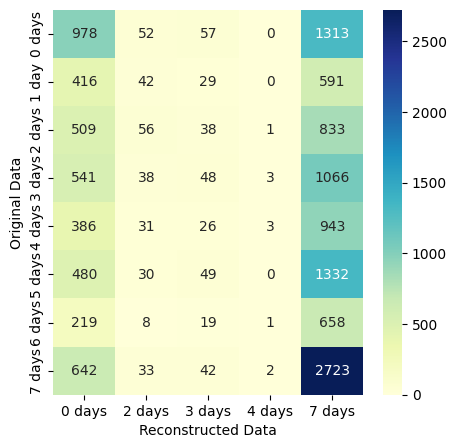

television_watching


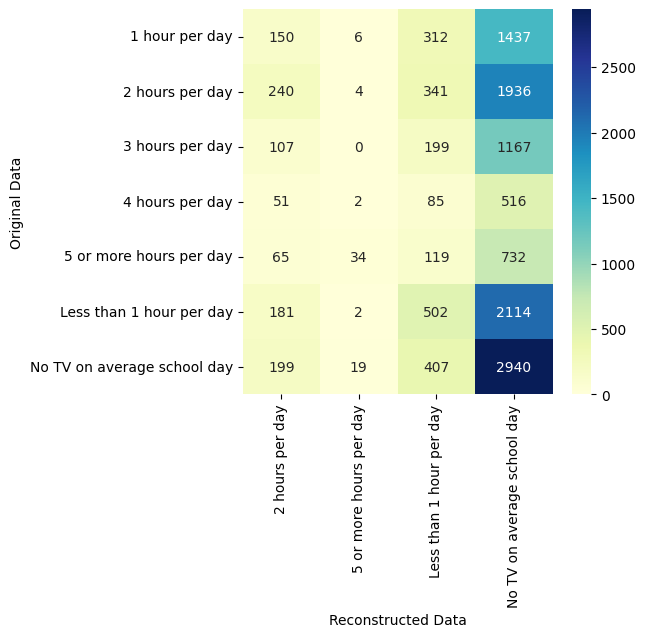

computer_not_school_work_use


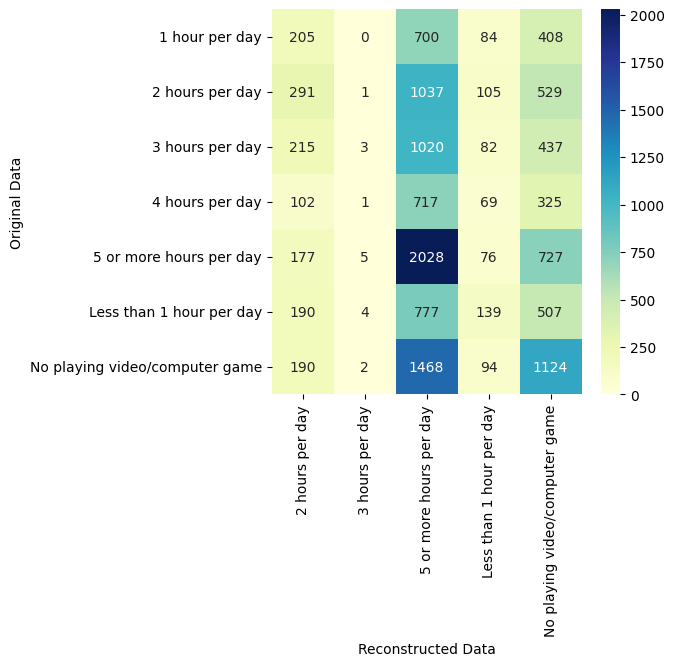

PE_attendance


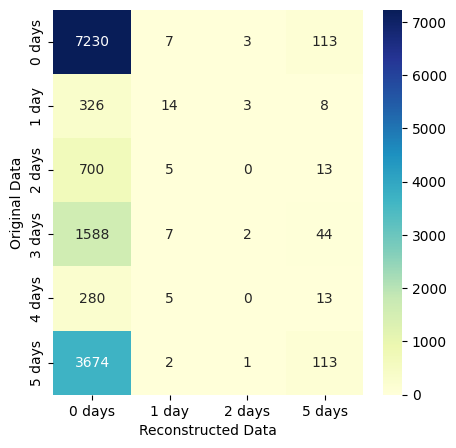

sports_team_participation


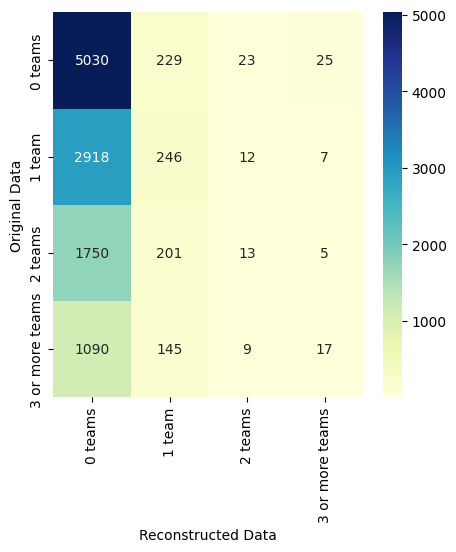

concussion_in_last_12_mos


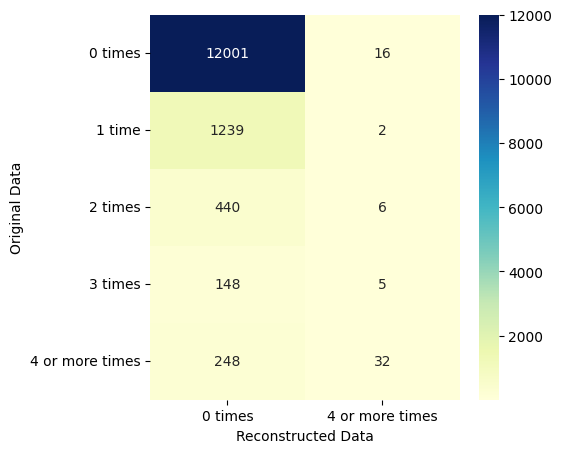

HIV_testing


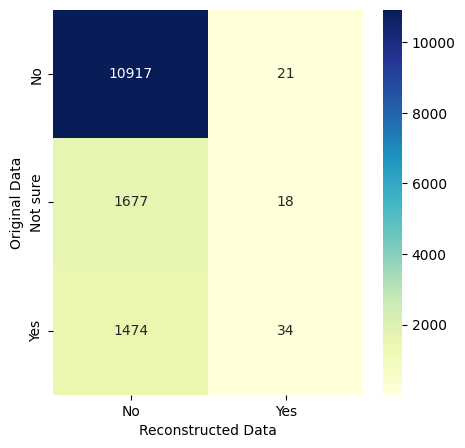

oral_health_care


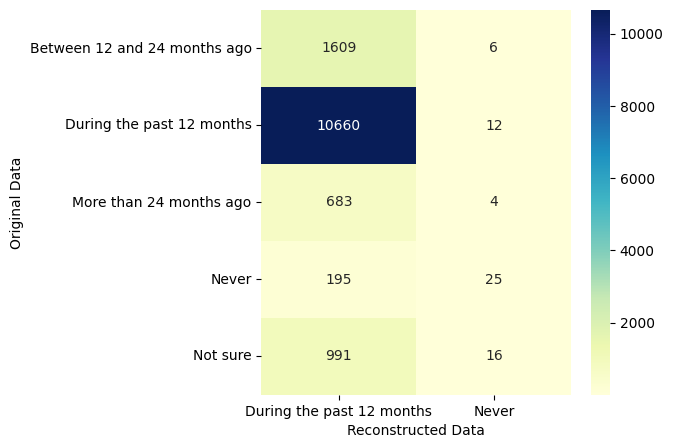

asthma


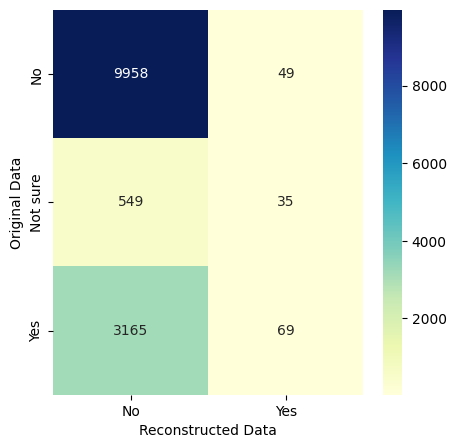

sleep_on_school_night


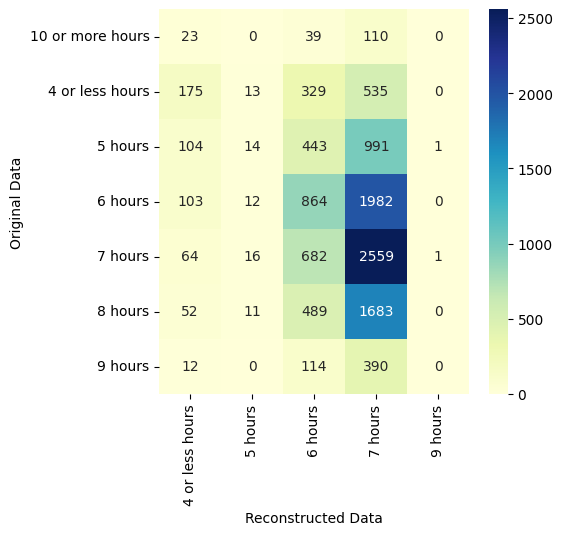

grades_in_school


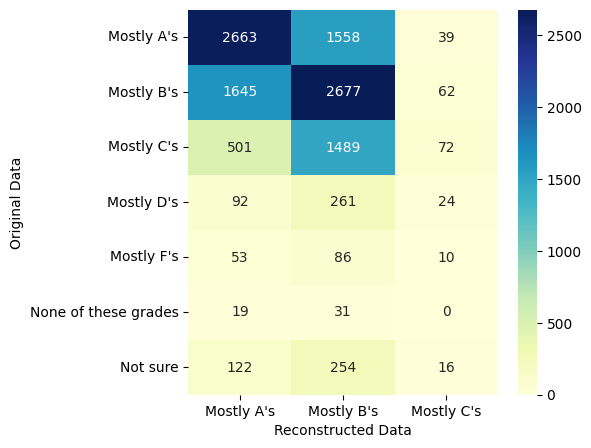

drive_when_using_marijuana


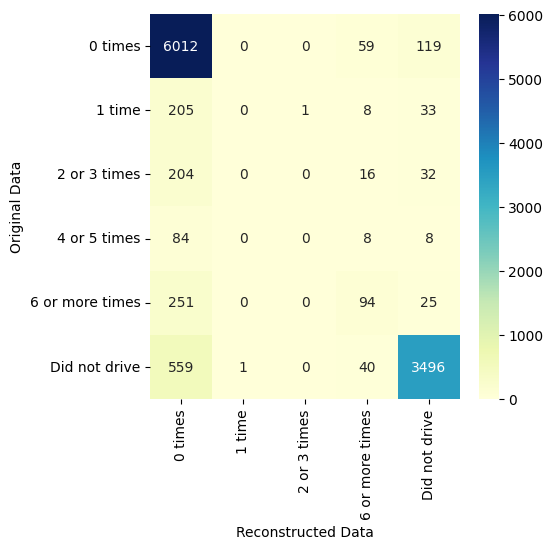

ever_used_LSD


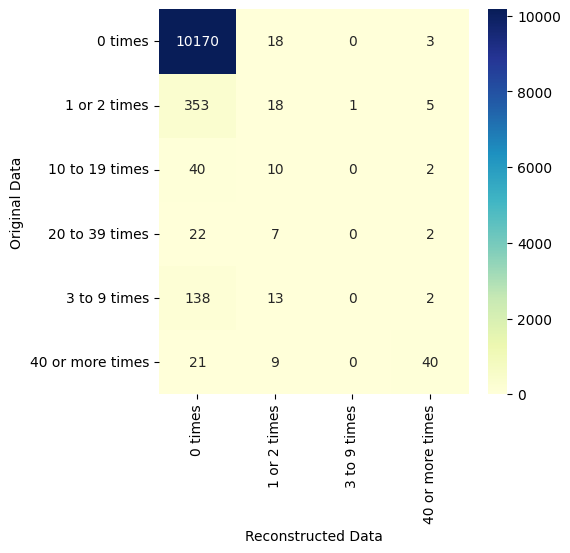

sports_drinks


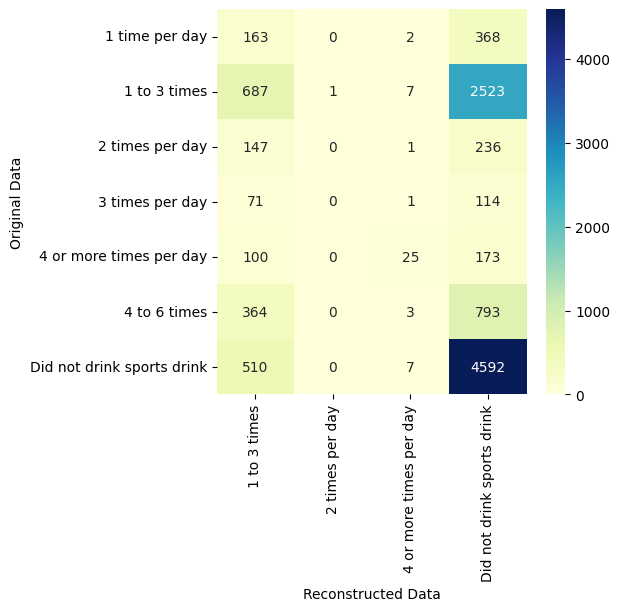

plain_water


food_allergies


muscle_stregthening


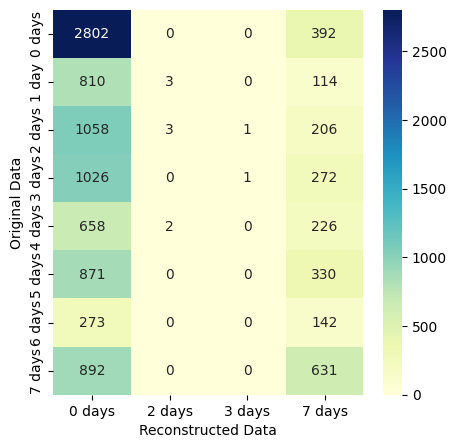

indoor_tanning


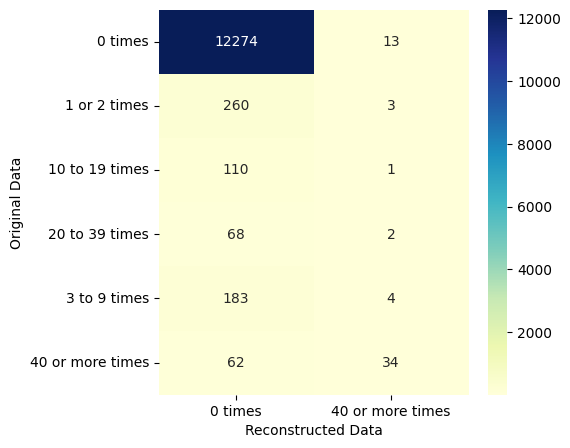

sunburn


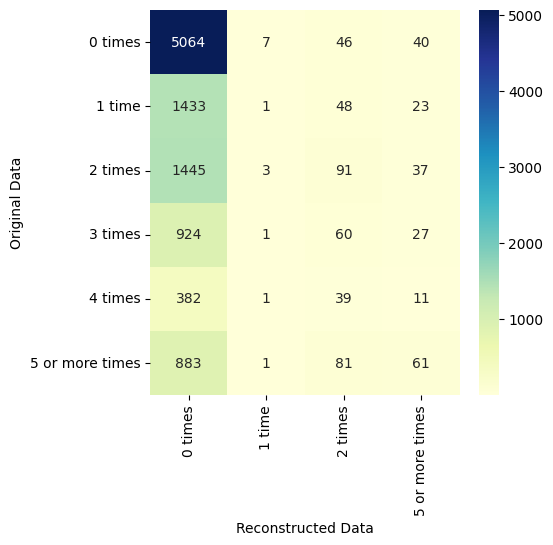

difficulty_concentrating


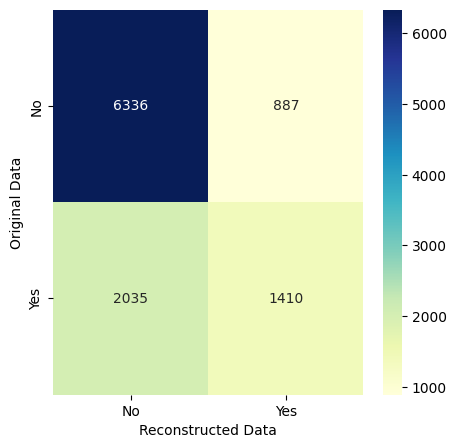

how_well_speak_English


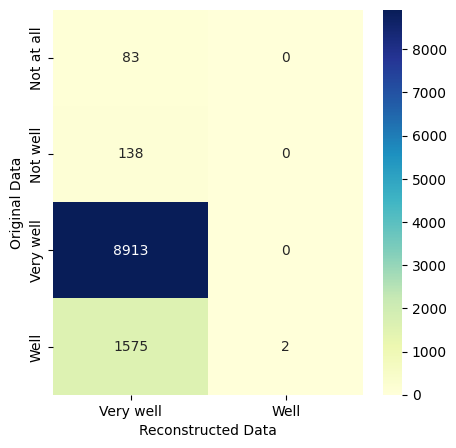

In [18]:
import matplotlib.pyplot as plt

def create_scatterplot_for_categorical(original_df, predicted_df, categ_attr):
  confusion_matrix = pd.crosstab(original_df[categ_attr], tabular_from_predicted[categ_attr], rownames=['Original Data'], colnames=['Reconstructed Data'])
  plt.figure(figsize=(5, 5))
  sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
  plt.show()



for v in var_types.keys():
  if var_types[v] == 'categorical':
    print(v)
    create_scatterplot_for_categorical(project_data, tabular_from_predicted, v)



## Examine Training Output Statistics

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

In [ ]:
model.predict(filled)[0,:]

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 2ms/step


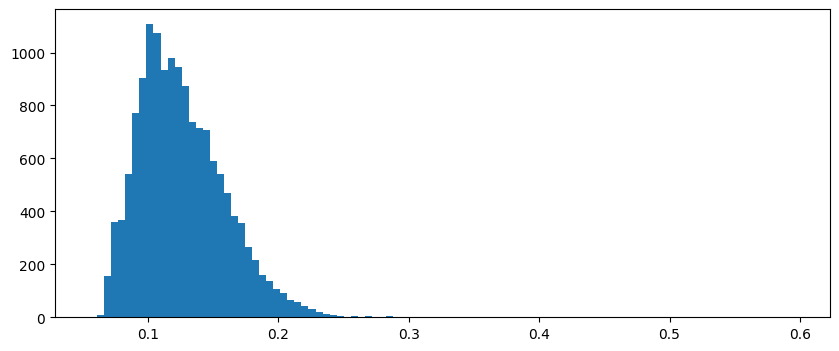

In [20]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = model.predict(filled)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions,filled)
plt.hist(normal_loss, bins=100)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [21]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.19245672819298165


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

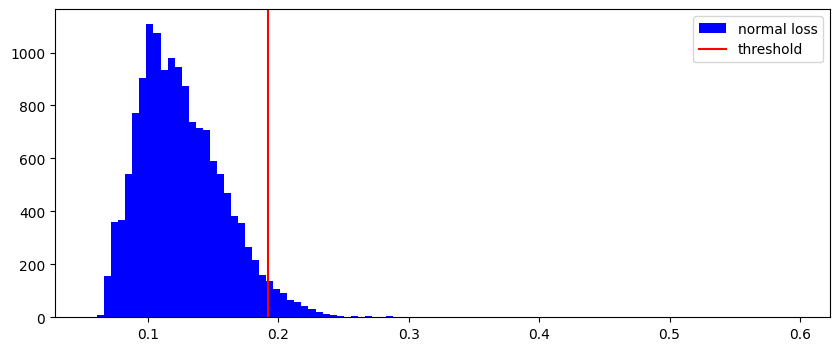

In [22]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=100, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [23]:
normal_loss

<tf.Tensor: shape=(14765,), dtype=float64, numpy=
array([0.14415757, 0.12784596, 0.1752039 , ..., 0.19872842, 0.08957255,
       0.15860181])>

In [24]:
reconstructed_error_df = pd.DataFrame()
reconstructed_error_df['Reconstructed_Error'] = normal_loss


# Create a GCS filesystem object
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Define the path to the file on GCS
gcs_path = "gs://autoencoder_census_models/data_with_reconstructed_errors.csv"

# Save the DataFrame to GCS
with fs.open(gcs_path, 'w') as gcs_file:
    reconstructed_error_df.to_csv(gcs_file)

reconstructed_error_df.head()

Reconstructed_Error
0             0.144158
1             0.127846
2             0.175204
3             0.186443
4             0.117887

Obtain the indices in descending order of the reconstruction errors.

In [25]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [26]:

k = 100  # Number of samples to select
samples_with_high_error = vectorized_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

weight  stheight  stweight       bmi    bmipct  \
7056  0.079344  0.507042  0.270315  0.107868  0.690107   
4424  0.027710  0.676056  0.296527  0.099609  0.643493   
3591  0.155289  0.816901  0.334273  0.096763  0.566970   
589   0.143844  0.605634  0.197642  0.082367  0.297289   
3139  0.051354  0.464789  0.316842  0.124080  0.940682   

      age__12 years old or younger  age__13 years old  age__14 years old  \
7056                           0.0                0.0                0.0   
4424                           0.0                0.0                0.0   
3591                           0.0                0.0                0.0   
589                            0.0                0.0                1.0   
3139                           0.0                0.0                0.0   

      age__15 years old  age__16 years old  ...  sunburn__2 times  \
7056                0.0                0.0  ...               0.0   
4424                0.0                1.0  ...               0.0   
3591                0.0                1.0  ...               0.0   
589                 0.0                0.0  ...               0.0   
3139                0.0                1.0  ...               0.0   

      sunburn__3 times  sunburn__4 times  sunburn__5 or more times  \
7056               0.0               0.0                       0.0   
4424               0.0               0.0                       0.0   
3591               1.0               0.0                       0.0   
589                0.0               0.0                       1.0   
3139               0.0               1.0                       0.0   

      difficulty_concentrating__No  difficulty_concentrating__Yes  \
7056                           0.0                            0.0   
4424                           0.0                            0.0   
3591                           1.0                            0.0   
589                            0.0                            1.0   
3139                           0.0                            1.0   

      how_well_speak_English__Not at all  how_well_speak_English__Not well  \
7056                                 0.0                               0.0   
4424                                 0.0                               0.0   
3591                                 1.0                               0.0   
589                                  1.0                               0.0   
3139                                 0.0                               0.0   

      how_well_speak_English__Very well  how_well_speak_English__Well  
7056                                0.0                           0.0  
4424                                0.0                           0.0  
3591                                0.0                           0.0  
589                                 0.0                           0.0  
3139                                1.0                           0.0  

[5 rows x 563 columns]

In [27]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = vectorized_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


weight  stheight  stweight       bmi  bmipct  \
7   0.356232       NaN       NaN       NaN     NaN   
12  0.211872       NaN       NaN       NaN     NaN   
15  0.043351       NaN       NaN       NaN     NaN   
29  0.638196       NaN       NaN  0.157129     NaN   
31  0.131839       NaN       NaN       NaN     NaN   

    age__12 years old or younger  age__13 years old  age__14 years old  \
7                            0.0                0.0                0.0   
12                           0.0                0.0                0.0   
15                           0.0                0.0                0.0   
29                           0.0                0.0                0.0   
31                           0.0                0.0                0.0   

    age__15 years old  age__16 years old  ...  sunburn__2 times  \
7                 0.0                0.0  ...               0.0   
12                0.0                0.0  ...               0.0   
15                0.0                0.0  ...               1.0   
29                0.0                0.0  ...               0.0   
31                0.0                0.0  ...               0.0   

    sunburn__3 times  sunburn__4 times  sunburn__5 or more times  \
7                0.0               0.0                       0.0   
12               0.0               0.0                       0.0   
15               0.0               0.0                       0.0   
29               0.0               0.0                       1.0   
31               0.0               0.0                       1.0   

    difficulty_concentrating__No  difficulty_concentrating__Yes  \
7                            0.0                            1.0   
12                           0.0                            1.0   
15                           1.0                            0.0   
29                           0.0                            1.0   
31                           0.0                            1.0   

    how_well_speak_English__Not at all  how_well_speak_English__Not well  \
7                                  0.0                               0.0   
12                                 0.0                               0.0   
15                                 0.0                               0.0   
29                                 1.0                               0.0   
31                                 0.0                               0.0   

    how_well_speak_English__Very well  how_well_speak_English__Well  
7                                 0.0                           1.0  
12                                1.0                           0.0  
15                                1.0                           0.0  
29                                0.0                           0.0  
31                                1.0                           0.0  

[5 rows x 563 columns]

In [28]:
anomaly_tuples.shape

(554, 563)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [29]:

reconstructed_data = model.predict(filled)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=vectorized_df.columns)

combined_df = pd.concat([vectorized_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 2ms/step


weight  stheight  stweight  bmi  bmipct  age__12 years old or younger  \
0  0.508875       NaN       NaN  NaN     NaN                           0.0   
1  0.347927       NaN       NaN  NaN     NaN                           0.0   
2  0.142144       NaN       NaN  NaN     NaN                           0.0   
3  0.161873       NaN       NaN  NaN     NaN                           0.0   
4  0.415955       NaN       NaN  NaN     NaN                           0.0   

   age__13 years old  age__14 years old  age__15 years old  age__16 years old  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   ...  sunburn__2 times  sunburn__3 times  sunburn__4 times  \
0  ...          0.065132          0.022069         -0.006557   
1  ...          0.122521          0.075502          0.039061   
2  ...          0.118993          0.077814          0.061824   
3  ...          0.200127          0.123818          0.049946   
4  ...          0.128449          0.088912          0.034333   

   sunburn__5 or more times  difficulty_concentrating__No  \
0                  0.031244                      0.674547   
1                  0.075076                      0.230557   
2                  0.083983                      0.344634   
3                  0.230163                      0.678813   
4                  0.080152                      0.295881   

   difficulty_concentrating__Yes  how_well_speak_English__Not at all  \
0                       0.240736                           -0.001807   
1                       0.605510                            0.000740   
2                       0.509776                            0.004760   
3                       0.312103                            0.007126   
4                       0.506447                            0.001522   

   how_well_speak_English__Not well  how_well_speak_English__Very well  \
0                          0.013335                           0.762406   
1                          0.030803                           0.684442   
2                          0.007051                           0.718327   
3                         -0.009364                           0.867371   
4                          0.025514                           0.694921   

   how_well_speak_English__Well  
0                      0.142273  
1                      0.148739  
2                      0.132396  
3                      0.120024  
4                      0.111986  

[5 rows x 1126 columns]

In [30]:
reconstructed_data1 = model.predict(vectorized_df)
reconstructed_df1 = pd.DataFrame(reconstructed_data, columns=vectorized_df.columns)
columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
vectorized_df[columns_to_modify] = vectorized_df[columns_to_modify].replace(0, np.nan)

reconstructed_df1.head()

462/462 [==============================] - 1s 2ms/step


weight  stheight  stweight       bmi    bmipct  \
0  0.195940  0.587383  0.303695  0.108749  0.656014   
1  0.263337  0.454057  0.275584  0.122809  0.673284   
2  0.205978  0.414373  0.250520  0.110779  0.653784   
3  0.302605  0.658366  0.323913  0.101454  0.611447   
4  0.281063  0.454114  0.248274  0.115395  0.623534   

   age__12 years old or younger  age__13 years old  age__14 years old  \
0                      0.004342           0.000399           0.004700   
1                     -0.000876           0.009795           0.213273   
2                      0.006186          -0.003660          -0.008078   
3                      0.007518          -0.004720          -0.007744   
4                     -0.007376           0.012458           0.249511   

   age__15 years old  age__16 years old  ...  sunburn__2 times  \
0           0.125434           0.287198  ...          0.065132   
1           0.291144           0.261416  ...          0.122521   
2           0.131690           0.287244  ...          0.118993   
3           0.102033           0.210764  ...          0.200127   
4           0.327658           0.224280  ...          0.128449   

   sunburn__3 times  sunburn__4 times  sunburn__5 or more times  \
0          0.022069         -0.006557                  0.031244   
1          0.075502          0.039061                  0.075076   
2          0.077814          0.061824                  0.083983   
3          0.123818          0.049946                  0.230163   
4          0.088912          0.034333                  0.080152   

   difficulty_concentrating__No  difficulty_concentrating__Yes  \
0                      0.674547                       0.240736   
1                      0.230557                       0.605510   
2                      0.344634                       0.509776   
3                      0.678813                       0.312103   
4                      0.295881                       0.506447   

   how_well_speak_English__Not at all  how_well_speak_English__Not well  \
0                           -0.001807                          0.013335   
1                            0.000740                          0.030803   
2                            0.004760                          0.007051   
3                            0.007126                         -0.009364   
4                            0.001522                          0.025514   

   how_well_speak_English__Very well  how_well_speak_English__Well  
0                           0.762406                      0.142273  
1                           0.684442                      0.148739  
2                           0.718327                      0.132396  
3                           0.867371                      0.120024  
4                           0.694921                      0.111986  

[5 rows x 563 columns]

Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [31]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in vectorized_df[categorical_vars]:
  probability = vectorized_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

In [32]:
numeric_vars = ['weight', 'stheight', 'stweight', 'bmi', 'bmipct']
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

cost1 = {}
mapped_categories1 = {}

for column in vectorized_df[categorical_vars]:
  probability = vectorized_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost1[column] = cost_value

for column, cost in cost1.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories1[column] = (reconstructed_df1[column] > cost).astype(int)

In [33]:
reconstructed_binary_df = pd.DataFrame(mapped_categories1)

selected_columns = reconstructed_df[['weight', 'stheight', 'stweight', 'bmi', 'bmipct']]
reconstructed_binary_df = pd.concat([reconstructed_binary_df, selected_columns], axis=1)

In [34]:
reconstructed_reverse_df = vectorizer.tabularize_vector(reconstructed_binary_df)

In [35]:
numeric_columns = ['weight', 'stheight', 'stweight', 'bmi', 'bmipct']
numeric_mae = {}

for column in numeric_columns:
    mae = mean_absolute_error(filled[column], reconstructed_reverse_df[column])
    numeric_mae[column] = mae

print("Numeric MAE:")
for column, mae in numeric_mae.items():
    print(f"{column}: {mae}")

categorical_columns = [c for c in project_data.columns.values if c not in numeric_columns]
categorical_accuracy = (project_data[categorical_columns] == reconstructed_reverse_df[categorical_columns]).mean()
print(f"Categorical Accuracy: {categorical_accuracy}")

Numeric MAE:
weight: 0.8680998934937073
stheight: 1.161262593413374
stweight: 66.25230096032915
bmi: 23.94450435889496
bmipct: 62.6140007481726
Categorical Accuracy: age                         0.177040
sex                         0.529428
grade                       0.251609
Hispanic_or_Latino          0.145953
race                        0.225737
                              ...   
muscle_stregthening         0.216390
indoor_tanning              0.831358
sunburn                     0.348188
difficulty_concentrating    0.489401
how_well_speak_English      0.603590
Length: 103, dtype: float64


\#2 approach for getting cost values:

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

mapped_categories_z_score = {}

cost_df = pd.DataFrame()

for column in vectorized_df[categorical_vars]:
    probability = vectorized_df[column].mean(axis=0)
    std = vectorized_df[column].std(axis=0)

    cost_values = []

    for index, value in vectorized_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = vectorized_df[column].mean(axis=0) - cost
    upper_bound = vectorized_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories_z_score[column] = mapped_values

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in vectorized_df.columns.values if c not in numeric_vars]

mapped_categories2 = {}

cost_df2 = pd.DataFrame()

for column in vectorized_df[categorical_vars]:
    probability = vectorized_df[column].mean(axis=0)
    std = vectorized_df[column].std(axis=0)

    cost_values = []

    for index, value in vectorized_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df2[column] = cost_values

    cost_df2.head()

for column, cost in cost_df2.items():
    lower_bound = vectorized_df[column].mean(axis=0) - cost
    mapped_values = (reconstructed_df1[column] > lower_bound).astype(int)
    mapped_categories2[column] = mapped_values

In [59]:
reconstructed_binary_df2 = pd.DataFrame(mapped_categories2)
reconstructed_binary_df2 = pd.concat([reconstructed_binary_df2, selected_columns], axis=1)

In [60]:
reconstructed_reverse_df2 = vectorizer.tabularize_vector(reconstructed_binary_df2)

In [61]:
for column in numeric_columns:
    mae = mean_absolute_error(filled[column], reconstructed_reverse_df2[column])
    numeric_mae[column] = mae

print("Numeric MAE:")
for column, mae in numeric_mae.items():
    print(f"{column}: {mae}")

categorical_accuracy = (project_data[categorical_columns] == reconstructed_reverse_df2[categorical_columns]).mean()
print(f"Categorical Accuracy: {categorical_accuracy}")

Numeric MAE:
weight: 0.8680998934937073
stheight: 1.161262593413374
stweight: 66.25230096032915
bmi: 23.94450435889496
bmipct: 62.6140007481726
Categorical Accuracy: age                         0.988283
sex                         0.991399
grade                       0.990247
Hispanic_or_Latino          0.977176
race                        0.977176
                              ...   
muscle_stregthening         0.725567
indoor_tanning              0.874704
sunburn                     0.725296
difficulty_concentrating    0.722519
how_well_speak_English      0.723129
Length: 103, dtype: float64


In [65]:
nan_rows_original = original_df[numeric_columns].isna().any(axis=1)
original_df_dropped = original_df.dropna(subset=numeric_columns)

dropped_indices = original_df_dropped.index

reconstructed_df_dropped2 = reconstructed_df.loc[dropped_indices]

for column in numeric_columns:
    mae = mean_absolute_error(original_df_dropped[column], reconstructed_df_dropped2[column])
    numeric_mae[column] = mae

print("Numeric MAE:")
for column, mae in numeric_mae.items():
    print(f"{column}: {mae}")

Numeric MAE:
weight: 0.7858274354862591
stheight: 1.1823273475363647
stweight: 67.42149705428784
bmi: 23.511133455658253
bmipct: 62.894526882531


**#3**

Group columns with similar names, normalize values within each group, and assign predicted values (0 or 1) by selecting the column with the maximum value within each group.

In [ ]:
import re

column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = column.rsplit('_', 1)[0]
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

normalized_df = categorical_df.copy()

for group in column_groups.values():
    column_sum = categorical_df[group].sum(axis=0)
    normalized_values = column_sum / column_sum.sum()
    normalized_df[group] = categorical_df[group] / normalized_values

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [73]:
reconstructed_binary_df3 = pd.concat([predicted_df, selected_columns], axis=1)
reconstructed_reverse_df3 = vectorizer.tabularize_vector(reconstructed_binary_df3)

In [74]:
for column in numeric_columns:
    mae = mean_absolute_error(filled[column], reconstructed_reverse_df3[column])
    numeric_mae[column] = mae

print("Numeric MAE:")
for column, mae in numeric_mae.items():
    print(f"{column}: {mae}")

categorical_accuracy = (project_data[categorical_columns] == reconstructed_reverse_df3[categorical_columns]).mean()
print(f"Categorical Accuracy: {categorical_accuracy}")

Numeric MAE:
weight: 0.8680998934937073
stheight: 1.161262593413374
stweight: 66.25230096032915
bmi: 23.94450435889496
bmipct: 62.6140007481726
Categorical Accuracy: age                         0.102608
sex                         0.712022
grade                       0.359160
Hispanic_or_Latino          0.470708
race                        0.222012
                              ...   
muscle_stregthening         0.142499
indoor_tanning              0.278700
sunburn                     0.238537
difficulty_concentrating    0.507213
how_well_speak_English      0.242804
Length: 103, dtype: float64
